
# Jonathan McNutt Kaggle ID: McNugget

In [2]:
#Prepare the notebook

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# color = sns.color_palette()
# sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

import numpy as np
from numpy import loadtxt
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

# Import classifiers to try out
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import sklearn.linear_model
import sklearn.svm
import xgboost as xgb #had to use "conda install -c conda-forge xgboost=0.6a2" command to install xgboost
from xgboost.sklearn import XGBClassifier

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap=ListedColormap(dark2_colors)

# Set random seed
np.random.seed(0)

In [294]:
#read in the training data file
df_train = pd.read_csv('train_data.csv')

In [422]:
#read in the test data file
df_test = pd.read_csv('test_data.csv')

In [295]:
#check training data dimensions
df_train.shape

(4584, 670)

In [424]:
#check test data dimensions
df_test.shape

#makes sense that we have one less column for test data, since the 'output' response variable is what we need to predict

(1732, 669)

In [296]:
#check columns
df_train.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       ...
       'z217', 'z218', 'z219', 'z220', 'z221', 'z222', 'subject', 'phase',
       'state', 'output'],
      dtype='object', length=670)

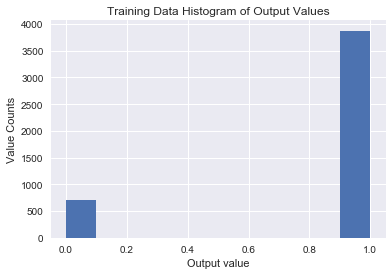

In [297]:
#get descriptive stats of the response variable we want to predict (output)

#histogram
plt.hist(df_train['output'])
plt.xlabel('Output value')
plt.ylabel('Value Counts')
plt.title('Training Data Histogram of Output Values');


In [298]:
#more specific look at distribution of 1's and 0's for output column
df_train['output'].value_counts()

1    3873
0     711
Name: output, dtype: int64

In [299]:
#print ratio of number of 1's (output value) to total rowcount
ratio = df_train['output'].value_counts()[1] / (df_train['output'].value_counts()[0] + df_train['output'].value_counts()[1])  
print(ratio)

0.844895287958


So far, we've discovered that roughly 84% of the training data is classified as output = '1'.  Now we will continue in our exploratory data analysis on the three categorical variables before jumping into some machine learning fun.

In [300]:
#correlation matrix of categorical variables
df_train_last_four = df_train[['subject','phase','state','output']]
df_train_last_four.head()

,subject,phase,state,output
0,A,3,B,0
1,A,3,C,0
2,A,3,B,0
3,A,3,A,0
4,A,4,C,0


So it appears that the rows are "grouped" by the 'subject' column, which Prof Henstock confirmed on Piazza represents individual persons, and the 'state' column represents some activity.  Perhaps some more data aggregation along these axes is needed to obtain the best prediction results.

In [301]:
#training value counts for the 'state' variable
df_train['state'].value_counts()

C    2106
B    1502
D     576
A     398
E       2
Name: state, dtype: int64

In [425]:
#test value counts for the 'state' variable
df_test['state'].value_counts()

C    841
B    525
D    253
A    112
E      1
Name: state, dtype: int64

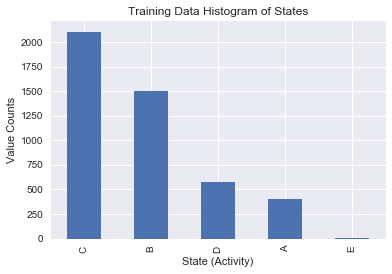

In [303]:
#Training data histogram of states
df_train['state'].value_counts().plot(kind='bar')
plt.xlabel('State (Activity)')
plt.ylabel('Value Counts')
plt.title('Training Data Histogram of States');

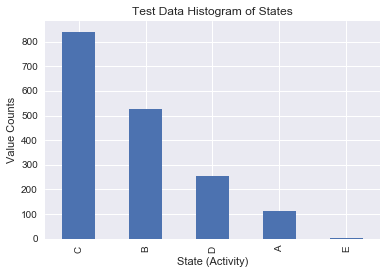

In [426]:
#Test data histogram of states
df_test['state'].value_counts().plot(kind='bar')
plt.xlabel('State (Activity)')
plt.ylabel('Value Counts')
plt.title('Test Data Histogram of States');

So roughly 45% of all training data observations (rows) are measurements related to state "C" (a particular activity), and 32% of training data observations are state "B".  This means that states "D", "A", and "E" combined account for less than 23% of the training data observations.  

We can visually verify that the distribution (value counts) for each state is roughly the same between the training data and the test data.  So far, so good for modeling purposes.

In [304]:
#Training value counts for the 'phase' variable
df_train['phase'].value_counts()

4    1291
1    1215
2    1063
3    1015
Name: phase, dtype: int64

In [428]:
#Test value counts for the 'phase' variable
df_test['phase'].value_counts()

4    559
1    488
3    358
2    327
Name: phase, dtype: int64

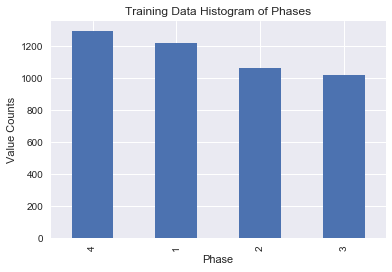

In [429]:
#Training data histogram of phases
df_train['phase'].value_counts().plot(kind='bar')
plt.xlabel('Phase')
plt.ylabel('Value Counts')
plt.title('Training Data Histogram of Phases');

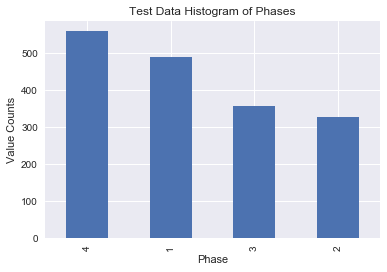

In [427]:
#Test data histogram of phases
df_test['phase'].value_counts().plot(kind='bar')
plt.xlabel('Phase')
plt.ylabel('Value Counts')
plt.title('Test Data Histogram of Phases');

Again, for the four possible phases, the training and test data sets are similarly distributed among the classes, although there are slightly more observations with phase = 4 and phase = 1 in the test data set.

In [306]:
#Training value counts for the 'subject' variable (individuals in this study)
df_train['subject'].value_counts()

I    663
G    518
B    513
K    468
L    444
D    420
A    380
C    361
F    330
M    306
H    181
Name: subject, dtype: int64

In [430]:
#Test value counts for the 'subject' variable (individuals in this study)
df_test['subject'].value_counts()

J    629
E    312
I    124
G     88
D     83
B     78
C     71
L     71
K     69
F     60
A     59
M     55
H     33
Name: subject, dtype: int64

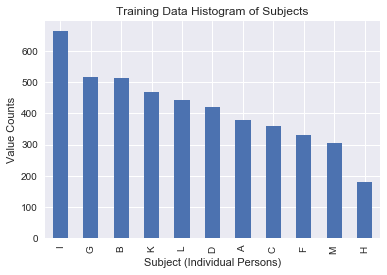

In [307]:
#Training data histogram of subjects
df_train['subject'].value_counts().plot(kind='bar')
plt.xlabel('Subject (Individual Persons)')
plt.ylabel('Value Counts')
plt.title('Training Data Histogram of Subjects')
plt.show();

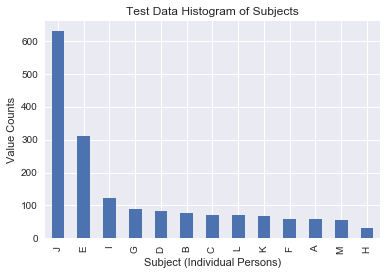

In [431]:
#Test data histogram of subjects
df_test['subject'].value_counts().plot(kind='bar')
plt.xlabel('Subject (Individual Persons)')
plt.ylabel('Value Counts')
plt.title('Test Data Histogram of Subjects')
plt.show();

YOWZA!  The two subject count histograms above for training and test data show that the test data set includes two classes not seen even once in the training data set.  These two subject classes are "J" and "E".  That means we should probably remove this column from BOTH the training AND test data sets, otherwise our model based on the training data would be off by a lot when taking this subject variable into account with the test data.  Good thing we looked at this variable!

In [448]:
subject_output_train = df_train_last_four.groupby(['subject', 'output']).size().unstack(fill_value=0)
print(subject_output_train)

output     0    1
subject          
A         11  369
B         72  441
C         88  273
D         26  394
F         73  257
G        263  255
H         25  156
I         25  638
K          0  468
L         39  405
M         89  217


In [449]:
subject_output_train = subject_output_train.reset_index()
print(subject_output_train.index)

RangeIndex(start=0, stop=11, step=1)


In [450]:
subject_output_train.columns = ['subject', 'zero', 'one']
print(subject_output_train.columns)

Index(['subject', 'zero', 'one'], dtype='object')


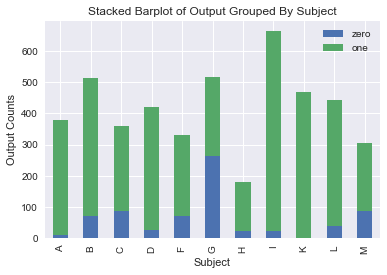

In [451]:
#stacked barplot of Training data subjects
subject_output_train.plot(x="subject", y=["zero", "one"], kind="bar", stacked=True)
plt.xlabel('Subject')
plt.ylabel('Output Counts')
plt.title('Stacked Barplot of Output Grouped By Subject')
plt.show();

In [452]:
output_subject_train = df_train_last_four.groupby(['output', 'subject']).size().unstack(fill_value=0)
output_subject_train = output_subject_train.reset_index()
print(output_subject_train.columns)

Index(['output', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'M'], dtype='object', name='subject')


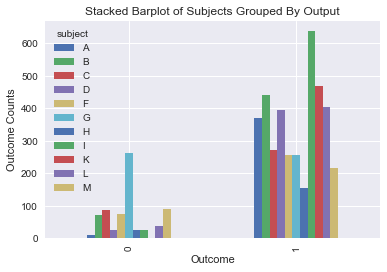

In [453]:
#unstacked barplot of Training data subjects grouped by output
output_subject_train.plot(x="output", y=["A", "B","C","D","F","G","H","I","K","L","M"], kind="bar", stacked=False)
plt.xlabel('Outcome')
plt.ylabel('Outcome Counts')
plt.title('Stacked Barplot of Subjects Grouped By Output')
plt.show();

Now these two plots above related to output and subject variables are very interesting.  We see here in the training data that at least ONE of the subjects (subject = "G") has a much higher ratio of output = '0' to ouput = '1', nearly 50%! The rest of the subjects have a much higher rate of output = '1' compared with output = '0'.  

In [455]:
state_output_train = df_train_last_four.groupby(['state', 'output']).size().unstack(fill_value=0)
state_output_train

output,0,1
state,,
A,54,344
B,211,1291
C,326,1780
D,120,456
E,0,2


In [456]:
print(state_output_train.index)

Index(['A', 'B', 'C', 'D', 'E'], dtype='object', name='state')


In [457]:
state_output_train = state_output_train.reset_index()
print(state_output_train.index)

RangeIndex(start=0, stop=5, step=1)


In [458]:
state_output_train.columns = ['state','zero', 'one']
print(state_output_train.columns)

Index(['state', 'zero', 'one'], dtype='object')


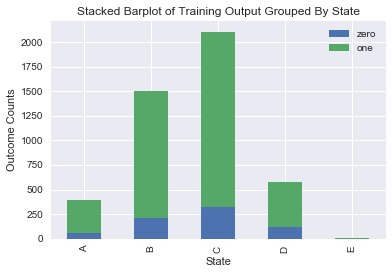

In [459]:
#stacked barplot of Training data states
state_output_train.plot(x="state", y=["zero", "one"], kind="bar", stacked=True)
plt.xlabel('State')
plt.ylabel('Outcome Counts')
plt.title('Stacked Barplot of Training Output Grouped By State')
plt.show();

In [460]:
# try grouping in reverse to show barplot from different perspective
output_state_train = df_train_last_four.groupby(['output', 'state']).size().unstack(fill_value=0)
output_state_train = output_state_train.reset_index()

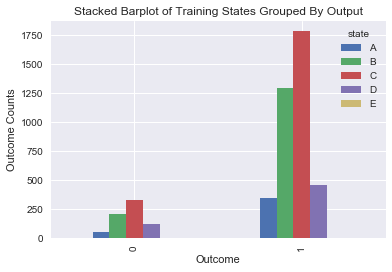

In [461]:
#unstacked barplot of Training data states grouped by output
output_state_train.plot(x="output", y=["A", "B","C","D","E"], kind="bar", stacked=False)
plt.xlabel('Outcome')
plt.ylabel('Outcome Counts')
plt.title('Stacked Barplot of Training States Grouped By Output')
plt.show();

In [463]:
phase_output_train = df_train_last_four.groupby(['phase', 'output']).size().unstack(fill_value=0)
phase_output_train

output,0,1
phase,,
1,210,1005
2,215,848
3,130,885
4,156,1135


In [464]:
phase_output_train = phase_output_train.reset_index()

In [465]:
phase_output_train.columns = ['phase','zero', 'one']
print(phase_output_train.columns)

Index(['phase', 'zero', 'one'], dtype='object')


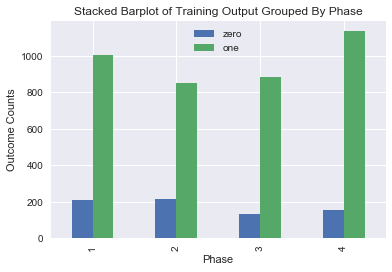

In [467]:
#stacked barplot of Training Output by phases
phase_output_train.plot(x="phase", y=["zero", "one"], kind="bar", stacked=False)
plt.xlabel('Phase')
plt.ylabel('Outcome Counts')
plt.title('Stacked Barplot of Training Output Grouped By Phase')
plt.show();

In [468]:
output_phase_train = df_train_last_four.groupby(['output', 'phase']).size().unstack(fill_value=0)
output_phase_train

phase,1,2,3,4
output,,,,
0,210,215,130,156
1,1005,848,885,1135


In [469]:
output_phase_train = output_phase_train.reset_index()
output_phase_train.columns = ['output','phase_1', 'phase_2','phase_3','phase_4']
print(output_phase_train.columns)

Index(['output', 'phase_1', 'phase_2', 'phase_3', 'phase_4'], dtype='object')


In [470]:
output_phase_train

,output,phase_1,phase_2,phase_3,phase_4
0,0,210,215,130,156
1,1,1005,848,885,1135


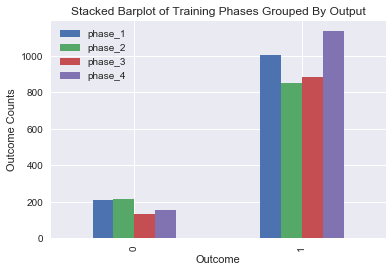

In [472]:
#stacked barplot of Training phases grouped by output
output_phase_train.plot(x="output", y=["phase_1", "phase_2","phase_3","phase_4"], kind="bar", stacked=False)
plt.xlabel('Outcome')
plt.ylabel('Outcome Counts')
plt.title('Stacked Barplot of Training Phases Grouped By Output')
plt.show();

So far, my conclusions regarding State, Subject, Phase and Outcome are that the strongest relationship exists between the subject and the outcome.  HOWEVER, as Prof Henstock mentioned in Piazza, the same subjects are not present in both training and test data, and even those that are present in both have differing distributions of observation counts. 

Therefore, from this point onwards I will attempt to predict the outcome WITHOUT using the subject variable, and see how my cross validation on the training set compares with the actual score on Kaggle, and adjust accordingly from there.

In [332]:
#Save the Training output column to a separate array
y = df_train['output'].values

In [333]:
#Drop the Training output column from the rest of the dataframe so only predictors remain
df_train = df_train.drop('output',1)

In [392]:
#Drop the Training subject column from the rest of the dataframe 
df_train = df_train.drop('subject',1)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z215,z216,z217,z218,z219,z220,z221,z222,phase,state
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,3.710000e-05,...,0.021695,0.010894,0.005242,0.024971,-1017.620978,-382.850838,-48.275711,-2.040336,3,B
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-1.420000e-05,...,0.037434,0.003062,0.001722,0.023595,91.229094,24.802230,1.783950,0.022620,3,C
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-2.790000e-05,...,-0.024443,0.029441,-0.010894,-0.036318,-188.232347,-17.474861,-1.005571,-0.021628,3,B
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-2.726060e-04,...,-0.018837,-0.033223,-0.034184,-0.047734,185.122907,-549.282067,542.193381,-178.049926,3,A
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,1.260000e-06,...,-0.010815,0.003117,0.001963,0.004084,35.207794,-78.143166,57.084208,-13.700212,4,C
5,0,0,0,0,-112.915717,1.460692,-3.620890,31.872719,0.008966,2.870000e-06,...,-0.006278,-0.003937,-0.016509,-0.002701,68.468100,-159.552693,123.355439,-31.642511,4,C
6,0,0,0,0,-380.665387,0.244520,-15.883882,374.574698,0.103286,-2.535020e-04,...,-0.038073,0.310532,0.060122,0.181599,-0.509000,-0.322042,-0.268659,-0.033342,4,C
7,0,0,0,0,-386.604055,0.261595,-8.788641,377.746106,0.062311,-6.979360e-04,...,-0.014172,0.004308,0.026389,-0.001390,-5.203930,-1.018364,-0.267002,-0.015707,4,C
8,0,0,0,1,-316.067981,0.063321,-14.192416,249.138026,0.005854,-1.510000e-05,...,0.015327,0.014646,0.011750,0.002515,-1383.819560,-2535.123020,-1548.717057,-315.499039,4,B
9,0,0,0,1,-39.243035,0.495243,-14.500527,3.857580,0.005821,3.190000e-06,...,0.023301,0.002547,-0.016651,-0.034821,-774.085217,401.745970,-70.010427,4.096719,4,C


In [473]:
#Drop the Test subject column from the rest of the dataframe 
df_test = df_test.drop('subject',1)

In [475]:
#Get dummy variables for Training categorical data: state
df_state_train = pd.get_dummies(df_train['state'], prefix = 'state')  
df_state_train.head() 

,state_A,state_B,state_C,state_D,state_E
0,0,1,0,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0


In [481]:
#Get dummy variables for Test categorical data: state
df_state_test = pd.get_dummies(df_test['state'], prefix = 'state')  
df_state_test.head() 

,state_A,state_B,state_C,state_D,state_E
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [476]:
#Get dummy variables for Training categorical data: phase
df_phase_train = pd.get_dummies(df_train['phase'], prefix = 'phase')   
df_phase_train.head() 

,phase_1,phase_2,phase_3,phase_4
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1


In [482]:
#Get dummy variables for Test categorical data: phase
df_phase_test = pd.get_dummies(df_test['phase'], prefix = 'phase')   
df_phase_test.head() 

,phase_1,phase_2,phase_3,phase_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [477]:
#Drop the original three Training categorical predictor columns (replaced by the dummy variable columns)
df_drop_train = df_train.drop(['state', 'phase'], axis=1)

In [483]:
#Drop the original three Test categorical predictor columns (replaced by the dummy variable columns)
df_drop_test = df_test.drop(['state', 'phase'], axis=1)

In [479]:
#Concatenate the two new Training dummy variable dataframes (minus the subject variable) 
# with the predictors training dataframe
df_dummies_train = pd.concat([df_drop_train, df_state_train, df_phase_train], axis = 1)

In [485]:
#Concatenate the two new Test dummy variable dataframes (minus the subject variable) 
# with the predictors test dataframe
df_dummies_test = pd.concat([df_drop_test, df_state_test, df_phase_test], axis = 1)

In [480]:
x = df_dummies_train.as_matrix()
x

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [398]:
#Try Random Forest classification model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 101)

clf = RandomForestClassifier(random_state = 101)
clf.fit(X_train,y_train)

print("Accuracy Score:",accuracy_score(y_test, clf.predict(X_test))) #predicting on 33% and getting accuracy
print("F1 Score:", f1_score(y_test,clf.predict(X_test))) #Do not try to optimize two metrics - decide on a metrics first


Accuracy Score: 0.828155981494
F1 Score: 0.903417533432


82.8% accuracy seems pretty good for a first try...until we recall that the two output classes are imbalanced for the training data set and roughly 84% of the training observations were classfied as '1'.  Therefore, if we simply classified EVERYTHING as '1', we would get a higher accuracy score!  Not good!  Some tuning is required, and perhaps also some feature engineering.

In [399]:
#code to prove the point that we haven't gotten very far on our first try with Random Forest out of the box.
#This code simply predicts that all outputs are '1', and still gets 84.5% accuracy
accuracy_score(y, np.repeat(1,y.shape))

0.84489528795811519

In [354]:
#Code from Section 6

# scores = []

# for ne in range(10,150,10):
#     clf = RandomForestClassifier(n_estimators = ne, random_state=82)
# #     score_list = cross_val_score(clf, x, y, cv=10,n_jobs=-1) #returns accuracy
# #     score_list = cross_val_score(clf, x, y, cv=10, scoring='accuracy') #same as above
#     score_list = cross_val_score(clf, x, y, cv=10, scoring='f1')
#     scores.append(score_list)

In [355]:
# plt.figure(figsize=(12,5))
# plt.xlabel('Number of trees')
# plt.ylabel('Classification score')
# plt.title('Classification score as a function of the number of trees')
# sns.boxplot(x=np.arange(10,150,10),y=scores)
# plt.show()

In [356]:
##The Random Forest for loop code took longer than a few minutes so I stopped it 


In [401]:
#try some number of trees with cross validation manually
#number of trees = 10
scores = []
clf = RandomForestClassifier(n_estimators = 10, random_state = 82)
score_list = cross_val_score(clf, x, y, cv = 10, scoring = 'f1')
scores.append(score_list)

In [402]:
#number of trees = 20
clf = RandomForestClassifier(n_estimators = 20, random_state = 82)
score_list = cross_val_score(clf, x, y, cv = 10, scoring = 'f1')
scores.append(score_list)

In [403]:
#number of trees = 30 (about 18 seconds)
clf = RandomForestClassifier(n_estimators = 30, random_state = 82)
score_list = cross_val_score(clf, x, y, cv = 10, scoring = 'f1')
scores.append(score_list)

In [404]:
#number of trees = 40 (about 26 seconds)
clf = RandomForestClassifier(n_estimators = 40, random_state = 82)
score_list = cross_val_score(clf, x, y, cv = 10, scoring = 'f1')
scores.append(score_list)

In [405]:
#number of trees = 50 
clf = RandomForestClassifier(n_estimators = 50, random_state = 82)
score_list = cross_val_score(clf, x, y, cv = 10, scoring = 'f1')
scores.append(score_list)

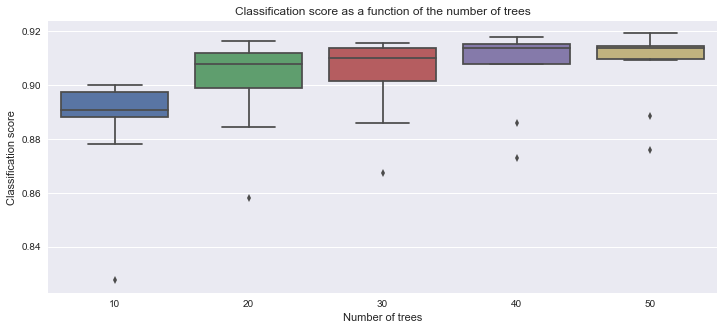

In [407]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
sns.boxplot(x=np.arange(10,60,10),y=scores)
plt.show()

After only 5 iterations, it seems that the F1 score is not improving by much for the increasing cost of CPU time, therfore I will say that 50 trees is sufficient to obtain a good prediction with limited computational resources available (to me, anyway).

In [409]:
#Now we will try Grid Search
param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'max_depth': [2,4,6,8,10],
    'class_weight':['balanced'],
    'min_samples_split':[2,4,6],
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1)
CV_rfc.fit(x, y)
print (CV_rfc.best_params_, CV_rfc.best_score_)

# clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 4, 
#                              n_estimators= 50, random_state=82)
# clf.fit(X_train,y_train)
# f1_score(y_test,clf.predict(X_test))  

{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 50} 0.805628272251


In [410]:
#The Grid Search did not improve the F1 score, as the number of trees = 50 plot above had a mean of 0.915

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)
f1_score(y_test,clf.predict(X_test))  

0.91083980762116168

In [411]:
#Now we try Feature importances

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=82)
clf.fit(x,y)
importance_list = clf.feature_importances_
name_list = df_dummies.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
df1  = pd.DataFrame([name_list,importance_list]).T
df1.columns = ['Features','Importances']

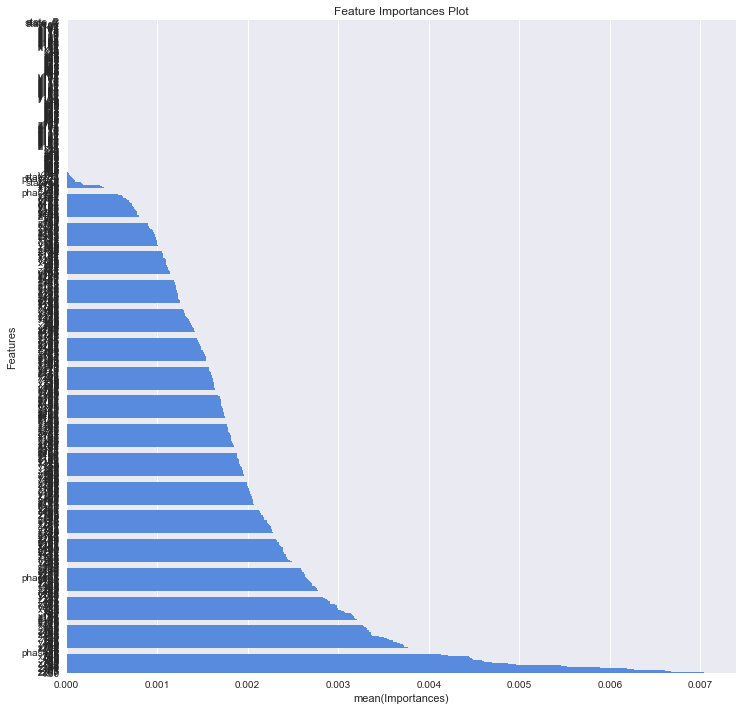

In [416]:
#Feature Importances Plot (first try)
f, ax = plt.subplots(figsize = (12,12))
sns.barplot(x='Importances',y='Features',data=df1, ci=None, color='#4286f4')
plt.title('Feature Importances Plot')
plt.show();

In [504]:
# YIKES!  There are simply way too many parameters to even see properly on the plot above, so we will take 0.004 as a first cut
df2 = df1[df1['Importances'] > 0.003]
df2

,Features,Importances
610,x33,0.00303253
611,x60,0.00306292
612,z7,0.00307634
613,x5,0.00314605
614,x187,0.00314721
615,z198,0.0031575
616,z179,0.00317195
617,y34,0.00317781
618,z157,0.00318915
619,y70,0.00320759


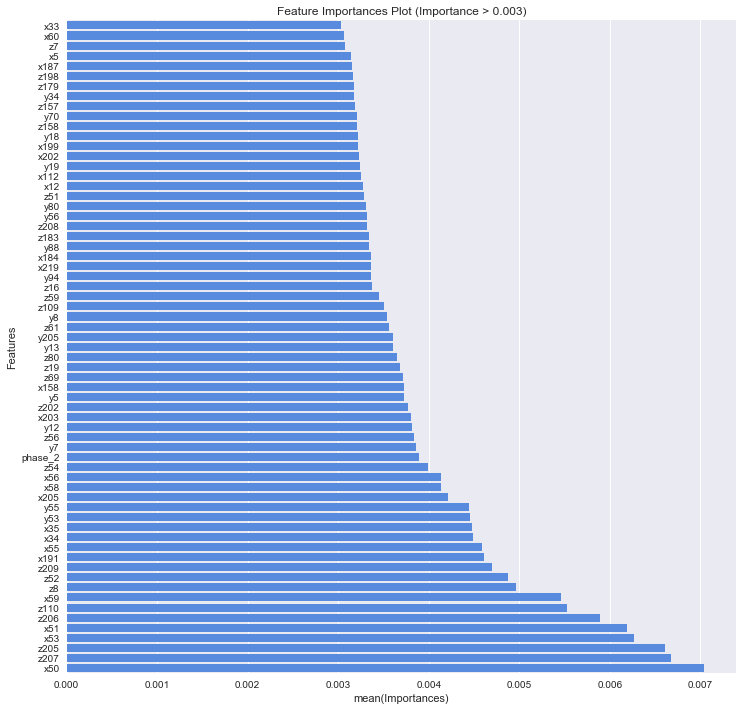

In [505]:
#Feaure Importances plot, second try
f, ax = plt.subplots(figsize = (12,12))
sns.barplot(x='Importances',y='Features',data=df2, ci=None, color='#4286f4')
plt.title('Feature Importances Plot (Importance > 0.003)')
plt.show();

In [419]:
clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)
#The easiest way to convert predict probabilities into predictions is to simply choose the class with probability > 0.5. 
#This is the default behavior of classifiers when we call their predict method. 

preds = (clf.predict_proba(X_test)[:,1]>0.5).astype(int)
(preds == clf.predict(X_test)).all()

True

In [489]:
"""
cutoff_predict(clf, X, cutoff)

Inputs:
clf: a **trained** classifier object
X: a 2D numpy array of features
cutoff: a float giving the cutoff value used to convert
        predicted probabilities into a 0/1 prediction.

Output:
a numpy array of 0/1 predictions.
"""
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)


clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)

#Let's try cutoff value of 0.5
preds = cutoff_predict(clf,X_test,0.5)
f1_score(y_test,preds)

0.91083980762116168

In [491]:
#Get the matrix form of the TEST data for making prediction
x_test = df_dummies_test.as_matrix()
x_test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [492]:
#Make an initial prediction to submit to Kaggle 

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=82)

#use 100% of training data for the fit!
clf.fit(x,y)

#cutoff value of 0.5
preds = cutoff_predict(clf,x_test,0.5)

In [501]:
print(preds)
preds.shape

[0 1 1 ..., 1 1 1]


(1732,)

In [488]:
df_dummies_test.index

RangeIndex(start=0, stop=1732, step=1)

In [496]:
#reset the Test data index so that we have a separate column with the index RowID's for Kaggle submission
df_dummies_test_index = df_dummies_test.reset_index()

RangeIndex(start=0, stop=1732, step=1)

In [503]:
#FIRST KAGGLE SUBMISSION EVER!!! (seriously, I have not done this before, this is an historic moment...)

submission1 = pd.DataFrame( {
    "id": df_dummies_test_index['index'],
    "output": preds
})
submission1.to_csv('McNutt_Jonathan_1.csv', index=False)

Ok, so my first Kaggle submission EVER yielded a public leaderboard score of 0.55508.  Not bad (wasn't dead last at least), but time to turn up the heat or get out of the kitchen!

In [510]:
#Let's try to only use the features from our Feature Importance plot above where 
# Feature Importance > 0.003 and try again!

important_features = df2.Features.as_matrix()
important_features

array(['x33', 'x60', 'z7', 'x5', 'x187', 'z198', 'z179', 'y34', 'z157',
       'y70', 'z158', 'y18', 'x199', 'x202', 'y19', 'x112', 'x12', 'z51',
       'y80', 'y56', 'z208', 'z183', 'y88', 'x184', 'x219', 'y94', 'z16',
       'z59', 'z109', 'y8', 'z61', 'y205', 'y13', 'z80', 'z19', 'z69',
       'x158', 'y5', 'z202', 'x203', 'y12', 'z56', 'y7', 'phase_2', 'z54',
       'x56', 'x58', 'x205', 'y55', 'y53', 'x35', 'x34', 'x55', 'x191',
       'z209', 'z52', 'z8', 'x59', 'z110', 'z206', 'x51', 'x53', 'z205',
       'z207', 'x50'], dtype=object)

In [511]:
#create a new dataframe with only the Training data columns deemed "important" by our Feature Importances plot
df_dummies_train_features = df_dummies_train[important_features]

In [513]:
df_dummies_train_features.head()

,x33,x60,z7,x5,x187,z198,z179,y34,z157,y70,...,z52,z8,x59,z110,z206,x51,x53,z205,z207,x50
0,2.186521,0.176434,-2.896664,-300.361218,-1.249572,-0.013517,-0.186434,-0.636314,-0.038386,53,...,-0.127339,6.355188,0.237597,0.865625,0.001721,-0.752755,-0.747351,0.275763,0.085922,-0.755435
1,2.128401,0.052196,-2.463686,-297.126090,-1.208622,-0.003117,-0.165493,-0.645812,-0.034744,54,...,-0.100494,3.896486,0.133186,0.868531,-0.084892,-0.743996,-0.739109,0.407122,-0.001900,-0.746452
2,2.185301,0.044377,-3.254425,-236.460253,-0.962199,-0.017191,-0.042681,-0.784368,-0.002830,59,...,-0.036312,0.497567,0.024621,0.926839,-0.037701,-0.593254,-0.587828,0.301952,0.075873,-0.595385
3,1.931538,0.890276,-6.089510,33.411458,0.183524,0.078337,1.601238,0.189910,0.327710,60,...,0.981982,388.858863,0.880749,0.964273,-0.342074,0.066654,0.083630,0.241572,0.254876,0.059469
4,2.195331,0.598811,-7.225891,-118.125214,-0.531465,0.070366,1.243751,-0.394056,0.263114,53,...,0.763429,235.125039,0.584741,0.934746,-0.159647,-0.301695,-0.291545,0.380735,0.086683,-0.306998


In [519]:
x_train_features = df_dummies_train_features.as_matrix()
x_train_features

array([[  2.18652146e+00,   1.76434181e-01,  -2.89666407e+00, ...,
          2.75763230e-01,   8.59222530e-02,  -7.55435407e-01],
       [  2.12840130e+00,   5.21957260e-02,  -2.46368631e+00, ...,
          4.07122081e-01,  -1.89976900e-03,  -7.46451735e-01],
       [  2.18530093e+00,   4.43770740e-02,  -3.25442450e+00, ...,
          3.01951989e-01,   7.58729560e-02,  -5.95384657e-01],
       ..., 
       [  1.95636360e+00,   8.72610458e-01,  -3.11399812e+00, ...,
          7.60300045e-01,   2.26774284e-01,  -9.85998154e-01],
       [  1.48409142e+00,   9.79538353e-01,   6.57551130e-02, ...,
          8.16176009e-01,   3.40949440e-02,  -9.73420024e-01],
       [  2.18541183e+00,   4.78413023e-01,  -3.01946528e+00, ...,
          7.89348330e-01,   1.12618530e-01,  -9.73349810e-01]])

In [520]:
#Try Random Forest again on this new feature-limited matrix
X_train, X_test, y_train, y_test = train_test_split(x_train_features, y, test_size = 0.33, random_state = 111)

clf = RandomForestClassifier(random_state = 111)
clf.fit(X_train,y_train)

print("Accuracy Score:",accuracy_score(y_test, clf.predict(X_test))) #predicting on 33% and getting accuracy
print("F1 Score:", f1_score(y_test,clf.predict(X_test))) #Do not try to optimize two metrics - decide on a metrics first



Accuracy Score: 0.841374752148
F1 Score: 0.910447761194


Well, at least the Accuracy and F1 score is improved over our original try without removing features (except for 'subject', of course).

In [517]:
# now reduce the TEST data down to the same important features we previously defined above.

df_dummies_test_features = df_dummies_test[important_features]

In [518]:
df_dummies_test_features.head()

,x33,x60,z7,x5,x187,z198,z179,y34,z157,y70,...,z52,z8,x59,z110,z206,x51,x53,z205,z207,x50
0,2.125159,0.829975,-11.235744,-18.839131,-0.142831,0.083006,1.384908,-0.409492,0.268608,53,...,0.831800,278.661107,0.817887,0.997451,-0.124054,-0.060533,-0.041361,0.238412,-0.017312,-0.063972
1,2.182643,0.686221,-3.940619,-21.203051,-0.043553,0.091490,1.349197,-0.413598,0.276487,50,...,0.829928,277.341634,0.716507,0.842617,-0.095541,-0.062938,-0.050803,0.625594,-0.106681,-0.067825
2,2.190192,0.723032,-13.264658,-83.843508,-0.382891,0.092381,1.383336,-0.306314,0.266749,47,...,0.845767,288.200244,0.665486,1.011875,-0.098799,-0.218701,-0.206849,0.241595,0.045188,-0.221724
3,2.217644,-0.068414,-5.516460,-192.522878,-0.798821,0.083035,1.177507,-0.342101,0.238170,48,...,0.702556,199.087062,0.165711,0.975294,-0.109013,-0.484326,-0.477695,0.365952,-0.026862,-0.486826
4,2.159252,0.091039,-7.363883,-188.095799,-0.768613,0.072397,1.176249,-0.340418,0.240328,59,...,0.713271,205.039452,0.091213,0.920237,-0.162033,-0.472910,-0.466495,0.202589,0.286453,-0.475563


In [521]:
x_test_features = df_dummies_test_features.as_matrix()
x_test_features

array([[  2.12515912,   0.8299752 , -11.23574384, ...,   0.23841189,
         -0.01731152,  -0.06397212],
       [  2.18264313,   0.68622087,  -3.94061907, ...,   0.62559431,
         -0.10668144,  -0.06782513],
       [  2.19019201,   0.72303204, -13.26465836, ...,   0.24159491,
          0.04518782,  -0.22172393],
       ..., 
       [  1.47631184,   0.87120002,  -3.78540202, ...,   0.58496773,
          0.14780209,  -0.99495059],
       [  2.12119914,   0.09392554,  -3.15998845, ...,   1.19872319,
          0.29355892,  -1.01595068],
       [  2.10275356,   0.38112544,  -3.25430819, ...,   1.24881995,
          0.37562866,  -0.99812227]])

In [522]:
#Make a second RandomForest prediction to submit to Kaggle 

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=111)

#use 100% of training data for the fit!
clf.fit(x_train_features,y)

#cutoff value of 0.5
preds2 = cutoff_predict(clf,x_test_features,0.5)

In [524]:
#Second Kaggle submission

submission2 = pd.DataFrame( {
    "id": df_dummies_test_index['index'],
    "output": preds2
})
submission2.to_csv('McNutt_Jonathan_2.csv', index=False)

My second RandomForest submission nailed a 0.57372, which moved me up 6 spots on the Leaderboard to number 11 out of 21!!  Woohoo!! I would take time to celebrate, but there's more work to be done...

For now, let's just jump to a Stacked Model so I can also see how several approaches compare against one another, and (if I have the time), come back to those individually and tune them for separate submissions.

In [525]:
#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.20, random_state=50) 
print (x.shape, X_train.shape, X_test.shape)

(4584, 675) (3667, 675) (917, 675)


In [536]:
#From Section 6 notebook plus Gaussian Naive Bayes classifier
estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB())
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.704685927842
AUC with QDA  :  0.5
AUC with KNN  :  0.657938946385
AUC with LogisticRegression  :  0.673063101912
AUC with Gaussian Naive Bayes  :  0.55980487279


So our initial comparison of classifiers WITHOUT tuning (except for RandomForest, I used the previously tuned parameters) shows that RandomForest, by itself, performs better than its competitors.  It's worth doubling back to tune each type of classifier explicitly, so that even if I go with a stacked model for my final Kaggle submission, it will be much, much better (we hope).

In [537]:
#From Section 6 notebook (plus Naive Bayes)

# Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

# Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

# Build Model3 - Level 0
Model3 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
#Predict on X_train, X_test
Model3_pred_test = Model3.predict_proba(X_test)
Model3_pred_train = Model3.predict_proba(X_train)

#Build Model4 - Level 0
Model4 = GaussianNB().fit(X_train,Y_train)
#Predict on X_train, X_test
Model4_pred_test = Model4.predict_proba(X_test)
Model4_pred_train = Model4.predict_proba(X_train)

In [538]:
#Model 5 - Level 1 
#Creating training attributes for Model5 (based on Model1, Model2, Model3, Model4 )
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train,Model4_pred_train])  
Model5 = LogisticRegression(random_state=50).fit(FeaturesTrain1,Y_train)

In [539]:
FeaturesTrain1.shape

(3667, 8)

In [541]:
#Creating test attributes for Model5 (based on Model1, Model2, Model3, Model4)
FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test,Model4_pred_test])

#Final predictions
final_pred = Model5.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)


AUC with Stacking:  0.681974989219


First Stacked Model is not so bad, but not better than RandomForest tuned by itself, although we did not yet tune each individual classifier, so the stacked model has a ways to go before "maxing" out as far as our efforts are concerned.  

For now, let's next try just the reduced features training data matrix as defined previously "x_train_features" and try the "vanilla" stacked model approach again.

In [542]:
#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_features, y, test_size=.20, random_state=50) 
print (x.shape, X_train.shape, X_test.shape)

(4584, 675) (3667, 65) (917, 65)


In [543]:
#From Section 6 notebook plus Gaussian Naive Bayes classifier
estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB())
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.748391907431
AUC with QDA  :  0.581118837142
AUC with KNN  :  0.686722904988
AUC with LogisticRegression  :  0.692899238177
AUC with Gaussian Naive Bayes  :  0.577040211298


All individual models did better with only the paired-down feature-importance training data! So then let's continue with this new stacked model and see how we do.

In [544]:
#From Section 6 notebook (plus Naive Bayes)

# Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

# Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

# Build Model3 - Level 0
Model3 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
#Predict on X_train, X_test
Model3_pred_test = Model3.predict_proba(X_test)
Model3_pred_train = Model3.predict_proba(X_train)

#Build Model4 - Level 0
Model4 = GaussianNB().fit(X_train,Y_train)
#Predict on X_train, X_test
Model4_pred_test = Model4.predict_proba(X_test)
Model4_pred_train = Model4.predict_proba(X_train)

In [545]:
#Model 5 - Level 1 
#Creating training attributes for Model5 (based on Model1, Model2, Model3, Model4 )
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train,Model4_pred_train])  
Model5 = LogisticRegression(random_state=50).fit(FeaturesTrain1,Y_train)

In [546]:
#SECOND stacked model:

#Creating test attributes for Model5 (based on Model1, Model2, Model3, Model4)
FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test,Model4_pred_test])

#Final predictions
final_pred = Model5.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)



AUC with Stacking:  0.706491663073


Great, we did see some improvement with limiting the feature space, from 68% to 70% AUC. Just for good measure, try stacking again but this time only predicting based on the state and phase dummy variables. Who knows, it might be more useful than the x, y, and z-coordinates?? Only testing will tell.

In [551]:
#reduce the training data predictors to ONLY state and phase dummy variables
df_state_phase_only = df_dummies_train[df_dummies_train.columns[-9:]]
df_state_phase_only.head()

,state_A,state_B,state_C,state_D,state_E,phase_1,phase_2,phase_3,phase_4
0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1


In [552]:
#get matrix form of state and phase dummy variable predictor dataframe
x_state_phase_only = df_state_phase_only.as_matrix()
x_state_phase_only

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1]], dtype=uint8)

In [553]:
#Try 3rd stacked model approach again with this new reduced state and phase only predictor matrix

#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_state_phase_only, y, test_size=.20, random_state=50) 
print (x.shape, X_train.shape, X_test.shape)

(4584, 675) (3667, 9) (917, 9)


In [554]:
#From Section 6 notebook plus Gaussian Naive Bayes classifier
estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB())
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.582906604858
AUC with QDA  :  0.509828230559
AUC with KNN  :  0.494394135403
AUC with LogisticRegression  :  0.573913863734
AUC with Gaussian Naive Bayes  :  0.572179998563


OK, ok, so I'm convinced now that we DO need at least SOME of the x,y,z coordinates for a better model.  No need to go further with the stacked model process for this predictor matrix.

Let's go for Stacked Model approach try number 4, which will be reducing the types of classifiers used at the base level, culling the underperforming classifiers and seeing how much difference it makes in the end.

In [555]:
#Stacked approach 4th try: full training predictor space again

#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.20, random_state=50) 
print (x.shape, X_train.shape, X_test.shape)

(4584, 675) (3667, 675) (917, 675)


In [557]:
#Remove Gaussian Naive Bayes, and QDA
estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.704685927842
AUC with KNN  :  0.65549985626
AUC with LogisticRegression  :  0.673063101912


In [558]:
#Build the Base level model with only two classifiers this time

# Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

# Build Model2 - Level 0
Model2 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)


In [559]:
#Model 3 - Level 1 
#Creating training attributes for Model3 (based on Model1 and Model2 )
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train])  
Model3 = LogisticRegression(random_state=50).fit(FeaturesTrain1,Y_train)

In [560]:
#Fourth stacked model:

#Creating test attributes for Model3 (based on Model1, Model2)
FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test])

#Final predictions
final_pred = Model3.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)


AUC with Stacking:  0.682136696852


Clearly, this fourth stacked model is only slightly better than our 1st stacked model utilizing the full training data predictor space (minus 'subject' as always). To me, that means that it is time to try and tune some of the hyperparameters in order to see more significant gains in performance with this approach.

Let's try XGBoost, maybe that will give us something new and shiny to use in our stacked model (eventually).

In [561]:
#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.20, random_state=22) 
print (x.shape, X_train.shape, X_test.shape)

(4584, 675) (3667, 675) (917, 675)


In [568]:
xgb.__version__

'0.6'

In [569]:
xb_mod_1 = xgb.XGBClassifier()
xb_mod_1.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [570]:
#accuracy score before tuning XGBoost model
y_pred = xb_mod_1.predict(X_test)

accuracy = accuracy_score(Y_test,y_pred)
print("Accuracy: %.5f%%" %  (accuracy * 100.0))

Accuracy: 83.75136%


First try for XGBoost is not bad, but again, since 84% of the training observations are '1', this is not exactly impressive yet. Let's continue.

In [571]:
n_estimators = [ 30, 50, 100, 200]  
learning_rate = [0.1, 0.5, 0.01, 0.05]  

param_grid1 = {'learning_rate':learning_rate, 'n_estimators':n_estimators}
param_grid1

{'learning_rate': [0.1, 0.5, 0.01, 0.05], 'n_estimators': [30, 50, 100, 200]}

In [572]:
#2nd try XGBoost model ( took 3.4 minutes!!! yikes! )

xb_mod_2 = xgb.XGBClassifier()
grid_search = GridSearchCV(xb_mod_2,param_grid=param_grid1, scoring="accuracy", verbose=1 )
grid_search.fit(X_train, Y_train) #Default 3 folds

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.5, 0.01, 0.05], 'n_estimators': [30, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [573]:
print(grid_search.best_score_)
print(grid_search.best_params_) 

0.851649850014
{'learning_rate': 0.05, 'n_estimators': 200}


In [575]:
#XGBoost model 3
xb_mod_3 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)

y_pred = xb_mod_3.predict(X_test)
#evaluate predictions
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0)) 

Accuracy: 83.86041%


Well, 83.86% IS better than 83.75%, but not for stealing 3 and half minutes of my life waiting for GridSearch to complete...

Let's just move on for now to the XGBoost Feature Importance plot to see what else we can mess with...

In [577]:
xb_mod_3.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.00152439,
        0.00304878,  0.00685976,  0.00838415,  0.        ,  0.00304878,
        0.00228659,  0.        ,  0.        ,  0.        ,  0.00228659,
        0.        ,  0.        ,  0.00228659,  0.        ,  0.        ,
        0.        ,  0.0007622 ,  0.        ,  0.00990854,  0.        ,
        0.0007622 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00685976,  0.0160061 ,  0.00457317,
        0.0007622 ,  0.0007622 ,  0.0007622 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00304878,  0.00457317,
        0.00381098,  0.00152439,  0.        ,  0.00152439,  0.00228659,
        0.        ,  0.        ,  0.00990854,  0.00762195,  0.        ,
        0.00762195,  0.00152439,  0.0007622 ,  0.0007622 ,  0.0007622 ,
        0.00457317,  0.        ,  0.        ,  0.0007622 ,  0.  

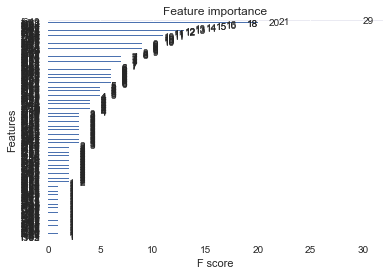

In [578]:
xgb.plot_importance(xb_mod_3)
plt.show();

Uh oh, this feature importance plot is unreadable!  Time to reduce to the top "n" features!

In [582]:
xgb_importance = pd.DataFrame({'feature': df_dummies_train.columns, 'importance_col': xb_mod_3.feature_importances_})
xgb_importance.sort_values(['importance_col', 'feature'], ascending=[0, 1], inplace=True)

In [601]:
#Top 50 most important XGBoost features
xgb_top_50 = xgb_importance[0:50]
xgb_top_50

,feature,importance_col
649,z206,0.022104
33,x34,0.016006
672,phase_2,0.015244
501,z58,0.013720
451,z8,0.013720
291,y70,0.012195
650,z207,0.012195
257,y36,0.011433
450,z7,0.011433
648,z205,0.010671


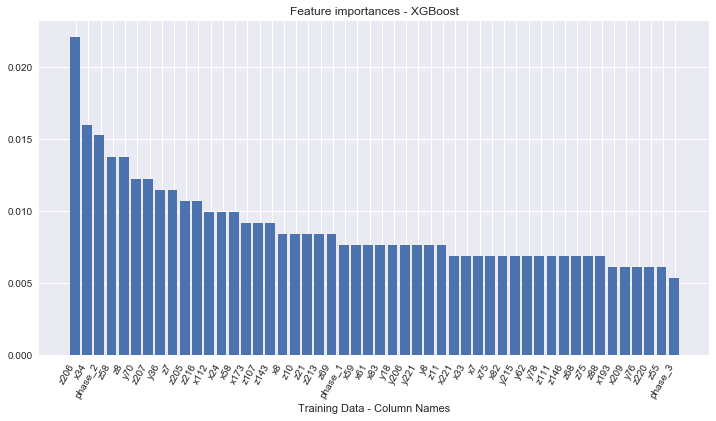

In [605]:
#Plot the top 50 important features from XGBoost
plt.figure(1,figsize=(12, 8))
h = plt.bar(range(len(xgb_top_50.importance_col)),xgb_top_50.importance_col,label=xgb_top_50.feature)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,xgb_top_50.feature[0:50],  ha='right', rotation=60)
plt.title("Feature importances - XGBoost")
plt.xlabel("Training Data - Column Names")
plt.show()

OK now let's try early stopping to see what we can learn there.

In [589]:
eval_set =  [(X_train, Y_train), (X_test, Y_test)]

In [590]:
xb_mod_3.fit(X_train, Y_train, eval_metric=["auc","error","logloss"],
          early_stopping_rounds=10, eval_set=eval_set,verbose=True)

[0]	validation_0-auc:0.677112	validation_0-error:0.146169	validation_0-logloss:0.66753	validation_1-auc:0.606603	validation_1-error:0.169029	validation_1-logloss:0.669466
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.696226	validation_0-error:0.145896	validation_0-logloss:0.644332	validation_1-auc:0.614952	validation_1-error:0.173391	validation_1-logloss:0.648249
[2]	validation_0-auc:0.715928	validation_0-error:0.145078	validation_0-logloss:0.623222	validation_1-auc:0.628157	validation_1-error:0.173391	validation_1-logloss:0.628959
[3]	validation_0-auc:0.72512	validation_0-error:0.144532	validation_0-logloss:0.603988	validation_1-auc:0.620765	validation_1-error:0.169029	validation_1-logloss:0.61141
[4]	validation_0-auc:0.729458	validation_0-error:0.144532	validation_0-logloss:0.586411	validation_1-auc:0.622318	validation_1-error:0.169029	validati

[47]	validation_0-auc:0.852081	validation_0-error:0.145896	validation_0-logloss:0.364936	validation_1-auc:0.713928	validation_1-error:0.165758	validation_1-logloss:0.41807
[48]	validation_0-auc:0.852921	validation_0-error:0.145896	validation_0-logloss:0.363701	validation_1-auc:0.714681	validation_1-error:0.165758	validation_1-logloss:0.417627
[49]	validation_0-auc:0.853975	validation_0-error:0.145896	validation_0-logloss:0.362425	validation_1-auc:0.71543	validation_1-error:0.165758	validation_1-logloss:0.417064
[50]	validation_0-auc:0.856722	validation_0-error:0.145896	validation_0-logloss:0.360907	validation_1-auc:0.716191	validation_1-error:0.166848	validation_1-logloss:0.416394
[51]	validation_0-auc:0.857169	validation_0-error:0.145896	validation_0-logloss:0.359731	validation_1-auc:0.718343	validation_1-error:0.166848	validation_1-logloss:0.415743
[52]	validation_0-auc:0.858489	validation_0-error:0.145896	validation_0-logloss:0.358354	validation_1-auc:0.71824	validation_1-error:0.16

[95]	validation_0-auc:0.908316	validation_0-error:0.140169	validation_0-logloss:0.320254	validation_1-auc:0.719775	validation_1-error:0.165758	validation_1-logloss:0.408887
[96]	validation_0-auc:0.909277	validation_0-error:0.140169	validation_0-logloss:0.319598	validation_1-auc:0.719724	validation_1-error:0.165758	validation_1-logloss:0.408787
[97]	validation_0-auc:0.910368	validation_0-error:0.140169	validation_0-logloss:0.318697	validation_1-auc:0.719681	validation_1-error:0.165758	validation_1-logloss:0.408806
[98]	validation_0-auc:0.910451	validation_0-error:0.139896	validation_0-logloss:0.318243	validation_1-auc:0.719553	validation_1-error:0.165758	validation_1-logloss:0.40886
[99]	validation_0-auc:0.911142	validation_0-error:0.139624	validation_0-logloss:0.317733	validation_1-auc:0.721033	validation_1-error:0.165758	validation_1-logloss:0.408604
[100]	validation_0-auc:0.911768	validation_0-error:0.139896	validation_0-logloss:0.317158	validation_1-auc:0.720922	validation_1-error:0

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)

With early stopping on our 3rd XGBoost model, the model stopped fitting after 111 iterations, with the best iteration at 101.  From 101 to 111 the logloss does not change much so it stopped.

In [591]:
# retrieve performance metrics
results = xb_mod_3.evals_result()
numrounds = len(results['validation_0']['error'])
x_axis = range(0, numrounds)

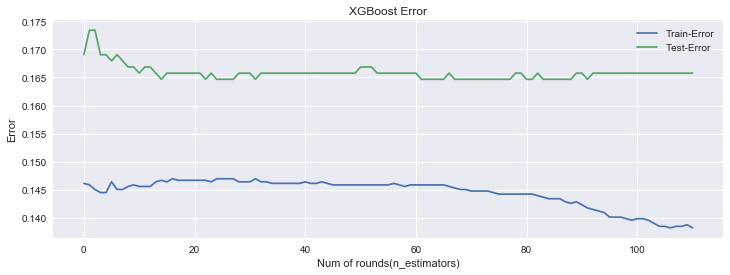

In [592]:
#Plot Error
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_axis, results['validation_0']['error'], label='Train-Error')
ax.plot(x_axis, results['validation_1']['error'], label='Test-Error')
ax.legend()
plt.xlabel('Num of rounds(n_estimators)')
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show();


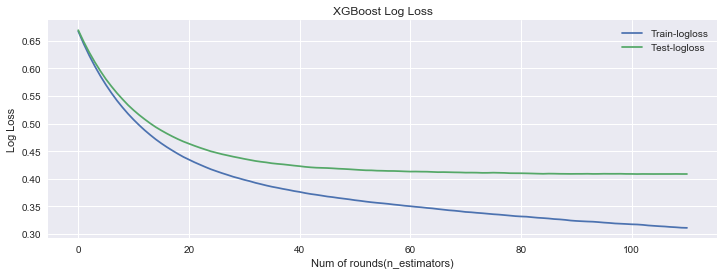

In [593]:
#Plot log loss
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train-logloss')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test-logloss')
ax.legend()
plt.xlabel('Num of rounds(n_estimators)')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show();

In [606]:
#Let's try to only use the top 50 features from our Feature Importance plot above where and try XGBoost again!

xgb_features = xgb_top_50.feature.as_matrix()
xgb_features

array(['z206', 'x34', 'phase_2', 'z58', 'z8', 'y70', 'z207', 'y36', 'z7',
       'z205', 'z216', 'x112', 'x24', 'x58', 'x173', 'z107', 'z143', 'x8',
       'z10', 'z21', 'z213', 'z69', 'phase_1', 'x59', 'x61', 'x83', 'y18',
       'y206', 'y221', 'y8', 'z11', 'x221', 'x33', 'x7', 'x75', 'x82',
       'y215', 'y62', 'y78', 'z111', 'z146', 'z68', 'z75', 'z88', 'x193',
       'x209', 'y76', 'z220', 'z55', 'phase_3'], dtype=object)

In [607]:
#create a new dataframe with only the Training data columns deemed "important" by our XGBoost Feature Importances plot
df_dummies_train_xgb_features = df_dummies_train[xgb_features]
df_dummies_train_xgb_features.head()

,z206,x34,phase_2,z58,z8,y70,z207,y36,z7,z205,...,z146,z68,z75,z88,x193,x209,y76,z220,z55,phase_3
0,0.001721,-0.726331,0,0.522332,6.355188,53,0.085922,0.000006,-2.896664,0.275763,...,-0.038610,37,2.049416,0.001464,0.007174,-13.529656,0.004305,-382.850838,-0.117904,1
1,-0.084892,-0.720823,0,0.570772,3.896486,54,-0.001900,0.000023,-2.463686,0.407122,...,-0.042187,41,1.925930,0.001799,0.010423,-13.271806,0.005594,24.802230,-0.090667,1
2,-0.037701,-0.573185,0,0.490339,0.497567,59,0.075873,0.000045,-3.254425,0.301952,...,0.007106,38,1.926429,0.000999,-0.006361,-10.585343,0.004207,-17.474861,-0.027209,1
3,-0.342074,0.192285,0,0.031987,388.858863,60,0.254876,-0.000016,-6.089510,0.241572,...,0.386663,28,1.957857,0.002657,-0.024576,2.450763,0.006230,-549.282067,0.994891,1
4,-0.159647,-0.256703,0,0.346458,235.125039,53,0.086683,-0.000007,-7.225891,0.380735,...,0.303931,43,1.827073,0.001526,-0.019066,-5.425387,0.004587,-78.143166,0.772565,0


In [608]:
#Get the matrix form of the XGBoost important features
x_train_xgb_features = df_dummies_train_xgb_features.as_matrix()
x_train_xgb_features

array([[  1.72082200e-03,  -7.26331055e-01,   0.00000000e+00, ...,
         -3.82850838e+02,  -1.17903769e-01,   1.00000000e+00],
       [ -8.48919660e-02,  -7.20822513e-01,   0.00000000e+00, ...,
          2.48022305e+01,  -9.06671060e-02,   1.00000000e+00],
       [ -3.77012670e-02,  -5.73185146e-01,   0.00000000e+00, ...,
         -1.74748609e+01,  -2.72091290e-02,   1.00000000e+00],
       ..., 
       [  6.24087380e-02,  -8.96029770e-01,   0.00000000e+00, ...,
          2.64078610e-02,  -3.17804000e-03,   0.00000000e+00],
       [ -3.54247790e-02,  -6.05205655e-01,   0.00000000e+00, ...,
         -6.89290200e-03,  -1.26597092e-01,   0.00000000e+00],
       [ -1.27244130e-02,  -9.28975582e-01,   0.00000000e+00, ...,
          3.38236583e+00,   2.96231329e-01,   0.00000000e+00]])

In [609]:
#Now we can train-test-split on the new x matrix of predictors deemed "important" by XGBoost
X_train, X_test, Y_train, Y_test = train_test_split(x_train_xgb_features, y, test_size=.20, random_state=22) 
print (x_train_xgb_features.shape, X_train.shape, X_test.shape)

(4584, 50) (3667, 50) (917, 50)


In [613]:
#XGBoost model 4: use only 100 estimators and learning rate of 0.05 this time based on our tuning above

xb_mod_4 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=100,seed=123).fit(X_train,Y_train)

y_pred = xb_mod_4.predict(X_test)
#evaluate predictions
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0)) 

Accuracy: 83.42421%


Hmmmm, not sure why the top 50 important features from XGBoost tuning would do WORSE than using ALL available features and no tuning at all (83.42% here compared with our first model with no tuning at 83.75%). Let's check AUC score just to compare directly with our other classifier types as shown in our stacked model approached previously.

In [615]:
y_pred_proba = xb_mod_4.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost : ", roc_auc)

AUC with XGBoost :  0.712897375355


Well, according to the AUC score metric, when compared against our other classifiers shown previously in the stacked model approach (also scored by AUC), XGBoost isn't too bad, roughly the same as RandomForest.

Maybe it's time to try the stacked model once again, but this time with XGBoost thrown into the mix.  Sounds like fun!

In [619]:
#Use the 50 most important features as found by XGBoost for the stacked model this time

#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_xgb_features, y, test_size=.20, random_state=444) 
print (x_train_xgb_features.shape, X_train.shape, X_test.shape)

(4584, 50) (3667, 50) (917, 50)


In [621]:
#Stacked Model Number 5: add XGBoost to the party

estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB()),
              ("XGBoost",xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123))
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.71113579875
AUC with QDA  :  0.644224975522
AUC with KNN  :  0.59927412066
AUC with LogisticRegression  :  0.667790163441
AUC with Gaussian Naive Bayes  :  0.598243202531
AUC with XGBoost  :  0.726048806206


Nice, so with only the top 50 important features (from XGBoost tuning), XGBoost is actually the best individual classifier in the mix so far!  Let's continue to see the final AUC for this stacked model number 5.

In [624]:
#Stacked Model 5 : Base level will only include RandomForest, QDA, and LogisticRegression

#Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=6,random_state=57).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

#Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

#Build Model3 - Level 0
Model3 = LogisticRegression(random_state=49).fit(X_train,Y_train)
#Predict on X_train, X_test
Model3_pred_test = Model3.predict_proba(X_test)
Model3_pred_train = Model3.predict_proba(X_train)



In [625]:
#Stacked Model 5 : Level 1 will use XGBoost

#Model 4 - Level 1 
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train])  
Model4 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(FeaturesTrain1,Y_train)

In [626]:
#Stacked Model 5

FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test])

#Final predictions
final_pred = Model4.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)


AUC with Stacking:  0.708833885667


OK, so this is my best Stacked Model so far! 

Let's try rearranging the models to get better performance (XGBoost still included).

In [ ]:
#Use the 50 most important features as found by XGBoost for the stacked model

#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_xgb_features, y, test_size=.20, random_state=444) 
print (x_train_xgb_features.shape, X_train.shape, X_test.shape)

In [627]:
#Stacked Model 6 : Base level will only include XGBoost, QDA, and KNN

#Build Model1 - Level 0
Model1 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

#Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

#Build Model3 - Level 0
Model3 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
#Predict on X_train, X_test
Model3_pred_test = Model3.predict_proba(X_test)
Model3_pred_train = Model3.predict_proba(X_train)



In [628]:
#Stacked Model 6 : Level 1 will use LogisticRegression

#Model 4 - Level 1 
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train])  
Model4 = LogisticRegression(random_state=53).fit(FeaturesTrain1,Y_train)

In [629]:
#Stacked Model 6 :

FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test])

#Final predictions
final_pred = Model4.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)


AUC with Stacking:  0.661764705882


OK so we will clearly have to work on this stacked model business.  

In the meantime, let's try another Kaggle submission for XGBoost and see how it does!

In [630]:
#create a new dataframe with only the Test data columns deemed "important" by our XGBoost Feature Importances plot
df_dummies_test_xgb_features = df_dummies_test[xgb_features]
df_dummies_test_xgb_features.head()

,z206,x34,phase_2,z58,z8,y70,z207,y36,z7,z205,...,z146,z68,z75,z88,x193,x209,y76,z220,z55,phase_3
0,-0.124054,-0.003840,0,0.229096,278.661107,53,-0.017312,0.000004,-11.235744,0.238412,...,0.317552,39,1.918159,0.001276,0.003965,-1.079066,0.003785,-821.094825,0.839949,0
1,-0.095541,-0.006949,0,0.570324,277.341634,50,-0.106681,-0.000023,-3.940619,0.625594,...,0.310509,44,1.897441,0.001648,-0.002510,-0.771502,0.006016,-943.446587,0.840098,0
2,-0.098799,-0.167646,0,0.244050,288.200244,47,0.045188,0.000012,-13.264658,0.241595,...,0.324680,41,2.006402,0.001415,-0.021110,-3.845917,0.003110,-1445.004242,0.853748,0
3,-0.109013,-0.458929,0,0.340983,199.087062,48,-0.026862,0.000010,-5.516460,0.365952,...,0.265230,34,1.822021,0.001715,-0.015108,-8.705269,0.003483,1163.146256,0.709934,0
4,-0.162033,-0.450096,0,0.122477,205.039452,59,0.286453,0.000009,-7.363883,0.202589,...,0.271604,35,1.526465,0.000952,0.005128,-8.421385,0.004509,1838.968578,0.721396,0


In [631]:
#Get the matrix form of the XGBoost important features for the Test data
x_test_xgb_features = df_dummies_test_xgb_features.as_matrix()
x_test_xgb_features

array([[ -1.24053760e-01,  -3.84040500e-03,   0.00000000e+00, ...,
         -8.21094825e+02,   8.39948952e-01,   0.00000000e+00],
       [ -9.55408130e-02,  -6.94861200e-03,   0.00000000e+00, ...,
         -9.43446587e+02,   8.40097547e-01,   0.00000000e+00],
       [ -9.87985210e-02,  -1.67646095e-01,   0.00000000e+00, ...,
         -1.44500424e+03,   8.53748024e-01,   0.00000000e+00],
       ..., 
       [ -1.32687192e-01,  -9.00229752e-01,   0.00000000e+00, ...,
          3.14852634e-01,   9.87396760e-02,   0.00000000e+00],
       [ -6.04286169e-01,  -8.32085192e-01,   0.00000000e+00, ...,
          4.76643830e-02,   2.32657745e-01,   0.00000000e+00],
       [ -5.95932081e-01,  -8.98858428e-01,   0.00000000e+00, ...,
         -2.64237580e-02,   1.55081928e-01,   0.00000000e+00]])

In [633]:
#Make an XGBoost prediction (using top 50 important features from XGBoost tuning) to submit to Kaggle 

#use 100% of training data for the fit!
xgb_model = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(x_train_xgb_features,y)

#cutoff value of 0.5
preds3 = cutoff_predict(xgb_model,x_test_xgb_features,0.5)

In [635]:
#check length of the prediction array to make sure it's 1732
len(preds3)

1732

In [636]:
#Third Kaggle submission

submission3 = pd.DataFrame( {
    "id": df_dummies_test_index['index'],
    "output": preds3
})
submission3.to_csv('McNutt_Jonathan_3.csv', index=False)

My 3rd Kaggle submission was a lowly 0.51029, which didn't do me any good on the leaderboard :( sadness, I know.  Back to the drawing board it seems.  

Perhaps it's time to try submitting one of my stacked models just to see what it does on the public leaderboard?

In [637]:
#Let's go back to the top 65 important features found by RandomForest, as opposed to XGBoost, for the stacked model
# But this time we will include XGBoost (was not on 'x_train_features')

#Split the full Training data (minus the 'subject' column) into training and test set 
#  - where the test set is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_features, y, test_size=.20, random_state=50) 
print (x_train_features.shape, X_train.shape, X_test.shape)

(4584, 65) (3667, 65) (917, 65)


In [638]:

estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB()),
              ("XGBoost",xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123))
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.748391907431
AUC with QDA  :  0.581118837142
AUC with KNN  :  0.686722904988
AUC with LogisticRegression  :  0.693159767141
AUC with Gaussian Naive Bayes  :  0.577040211298
AUC with XGBoost  :  0.727675362944


In [654]:
#Stacked Model Number 7 : using x_train_features found by RandomForest plus XGBoost classifier

#Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=100,max_depth=5 ,random_state=57).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

#Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

# #Build Model3 - Level 0
# Model3 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
# #Predict on X_train, X_test
# Model3_pred_test = Model3.predict_proba(X_test)
# Model3_pred_train = Model3.predict_proba(X_train)

#Build Model4 - Level 0
Model4 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)
#Predict on X_train, X_test
Model4_pred_test = Model4.predict_proba(X_test)
Model4_pred_train = Model4.predict_proba(X_train)


In [655]:
#Stacked Model Number 7 :

#Model 5 - Level 1 

# FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train,Model4_pred_train])
# FeaturesTrain1 = np.hstack([Model1_pred_train,Model3_pred_train,Model4_pred_train]) 
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model4_pred_train]) 

Model5 = LogisticRegression(random_state=49).fit(FeaturesTrain1,Y_train)

In [656]:
#Stacked Model Number 7 :
# FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test,Model4_pred_test])
# FeaturesTest1 = np.hstack([Model1_pred_test,Model3_pred_test,Model4_pred_test])
FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model4_pred_test])

#Final predictions
final_pred = Model5.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)

AUC with Stacking:  0.72659731206


OK, not bad, highest AUC stacked model so far.

Now let's try to predict using all of the observations with only the 'x_train_features' predictors, but with our shiny, new stacked model.

In [657]:
#Kaggle 4th submission: Stacked Model Number 7

#Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=100,max_depth=5 ,random_state=57).fit(x_train_features,y)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(x_test_features)
Model1_pred_train = Model1.predict_proba(x_train_features)

#Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(x_test_features)
Model2_pred_train = Model2.predict_proba(x_train_features)

#Build Model3 - Level 0
Model3 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)
#Predict on X_train, X_test
Model3_pred_test = Model3.predict_proba(x_test_features)
Model3_pred_train = Model3.predict_proba(x_train_features)


In [658]:
#Stacked Model Number 7 :

#Model 4 - Level 1 

FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train]) 

Model4 = LogisticRegression(random_state=49).fit(FeaturesTrain1,y)

In [661]:
#Stacked Model Number 7 :

FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test])

#cutoff value of 0.5
preds4 = cutoff_predict(Model4,FeaturesTest1,0.5)

In [663]:
len(preds4)

1732

In [664]:
#Fourth Kaggle submission

submission4 = pd.DataFrame( {
    "id": df_dummies_test_index['index'],
    "output": preds4
})
submission4.to_csv('McNutt_Jonathan_4.csv', index=False)

My 4th Kaggle submission scored a 0.53607, which is better than my 3rd, but still not an improvement over my 2nd submission (aw man).

Time to try Support Vector Machines anyone??

Before I switch over to SVM classifier, I'll try my Stacked Model approach one more time, but this time the features will be "manually" limited (i.e. 'eye-balled').

What I mean by this is, there are several columns with all the same values (either '0' or '1'), so therefore they will not be very important to the 'output' response variable we are predicting.

Anyway, it's worth a shot, right?

In [ ]:
#Notes to myself regarding which Test data columns seem to be 'static', that is, not changing in value.

# x1,x2,x3,x14,x39,x47,x48,x57,x72,x73,x74,x81,x86,x87,x91,x92,x93,x96,x97,x98,x99,x103,x104,x105

# x113,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132

# That's 40 unique x-coordinate columns

# the y columns seem to match fairly well with the x columns, so I will just drop the same ones

# the z columns seem to also match with x and y static columns, so I will drop the same ones

# Therefore, I will be dropping 120 total columns, and should check to make sure this is the case.


In [666]:
df_dummies_train.shape

(4584, 675)

In [668]:
list(df_dummies_train)[0:10]

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

In [15]:
#Get a list of x-coordinates to drop, then y-coordinates, then z-coordinates, then combine, then drop from dataframe

x_coordinates = ['x1','x2','x3','x14','x39','x47','x48','x57','x72','x73','x74','x81','x86','x87','x91','x92',
                 'x93','x96','x97','x98','x99','x103','x104','x105','x113','x118','x119','x120','x121','x122',
                 'x123','x124','x125','x126','x127','x128','x129','x130','x131','x132']

In [16]:
y_coordinates = ['y1','y2','y3','y14','y39','y47','y48','y57','y72','y73','y74','y81','y86','y87','y91','y92',
                 'y93','y96','y97','y98','y99','y103','y104','y105','y113','y118','y119','y120','y121','y122',
                 'y123','y124','y125','y126','y127','y128','y129','y130','y131','y132']

In [17]:
z_coordinates = ['z1','z2','z3','z14','z39','z47','z48','z57','z72','z73','z74','z81','z86','z87','z91','z92',
                 'z93','z96','z97','z98','z99','z103','z104','z105','z113','z118','z119','z120','z121','z122',
                 'z123','z124','z125','z126','z127','z128','z129','z130','z131','z132']

In [681]:
columns_to_drop = x_coordinates

In [683]:
columns_to_drop.extend(y_coordinates)

In [685]:
columns_to_drop.extend(z_coordinates)

In [686]:
#Final list of columns to drop from the training AND test data 
print(columns_to_drop)

['x1', 'x2', 'x3', 'x14', 'x39', 'x47', 'x48', 'x57', 'x72', 'x73', 'x74', 'x81', 'x86', 'x87', 'x91', 'x92', 'x93', 'x96', 'x97', 'x98', 'x99', 'x103', 'x104', 'x105', 'x113', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'y1', 'y2', 'y3', 'y14', 'y39', 'y47', 'y48', 'y57', 'y72', 'y73', 'y74', 'y81', 'y86', 'y87', 'y91', 'y92', 'y93', 'y96', 'y97', 'y98', 'y99', 'y103', 'y104', 'y105', 'y113', 'y118', 'y119', 'y120', 'y121', 'y122', 'y123', 'y124', 'y125', 'y126', 'y127', 'y128', 'y129', 'y130', 'y131', 'y132', 'y1', 'y2', 'y3', 'y14', 'y39', 'y47', 'y48', 'y57', 'y72', 'y73', 'y74', 'y81', 'y86', 'y87', 'y91', 'y92', 'y93', 'y96', 'y97', 'y98', 'y99', 'y103', 'y104', 'y105', 'y113', 'y118', 'y119', 'y120', 'y121', 'y122', 'y123', 'y124', 'y125', 'y126', 'y127', 'y128', 'y129', 'y130', 'y131', 'y132', 'y1', 'y2', 'y3', 'y14', 'y39', 'y47', 'y48', 'y57', 'y72', 'y73', 'y74', 'y81', 'y86', 'y87', 'y91', 'y92', 'y

In [687]:
#Drop the columns found above from the Training data
df_dummies_train_dropped_columns = df_dummies_train.drop(columns_to_drop, axis=1)

In [689]:
df_dummies_train_dropped_columns.shape

(4584, 555)

In [692]:
#Drop the columns found above from the Test data
df_dummies_test_dropped_columns = df_dummies_test.drop(columns_to_drop, axis=1)

In [693]:
df_dummies_test_dropped_columns.shape

(1732, 555)

In [695]:
#Get matrix form of the Training data with columns dropped
x_train_dropped = df_dummies_train_dropped_columns.as_matrix()
x_train_dropped

array([[   1.        , -300.3612177 ,    0.88635993, ...,    0.        ,
           1.        ,    0.        ],
       [   1.        , -297.12609   ,    0.62221072, ...,    0.        ,
           1.        ,    0.        ],
       [   1.        , -236.4602528 ,    0.42363992, ...,    0.        ,
           1.        ,    0.        ],
       ..., 
       [   0.        , -388.2530177 ,    3.22087347, ...,    0.        ,
           0.        ,    1.        ],
       [   1.        , -371.0906383 ,    3.31016435, ...,    0.        ,
           0.        ,    1.        ],
       [   1.        , -385.8211091 ,    1.63955731, ...,    0.        ,
           0.        ,    1.        ]])

In [696]:
#Get matrix form of the Test data with columns dropped
x_test_dropped = df_dummies_test_dropped_columns.as_matrix()
x_test_dropped

array([[   1.        ,  -18.83913086,    2.30658368, ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,  -21.20305061,    2.11295605, ...,    0.        ,
           0.        ,    0.        ],
       [   1.        ,  -83.84350793,    2.09719147, ...,    0.        ,
           0.        ,    0.        ],
       ..., 
       [   1.        , -393.4185422 ,    3.14493045, ...,    0.        ,
           0.        ,    1.        ],
       [   0.        , -393.9763222 ,    0.92173684, ...,    0.        ,
           0.        ,    1.        ],
       [   0.        , -392.6276484 ,    1.47052734, ...,    0.        ,
           0.        ,    1.        ]])

In [698]:
#Stacked Model attempt number 8: train on 555 predictors rather than 675

#Split the limited Training data from above into training and test set 
#  - where the test set is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_dropped, y, test_size=.15, random_state=50) 
print (x_train_dropped.shape, X_train.shape, X_test.shape)

(4584, 555) (3896, 555) (688, 555)


In [699]:
#Stacked Model attempt number 8: train on 555 predictors rather than 675

estimators = [("RandomForest", RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split= 6,random_state=50)),
              ("QDA",QuadraticDiscriminantAnalysis()),
              ("KNN",KNeighborsClassifier(n_neighbors = 15, weights='distance')),
              ("LogisticRegression",LogisticRegression(random_state=57)),
              ("Gaussian Naive Bayes",GaussianNB()),
              ("XGBoost",xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123))
             ]
for (name, estimator) in estimators:
    Y_pred_test = estimator.fit(X_train,Y_train).predict_proba(X_test)
    #AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUC with",name, " : " ,roc_auc)

AUC with RandomForest  :  0.689854452055
AUC with QDA  :  0.504807692308
AUC with KNN  :  0.633619270285
AUC with LogisticRegression  :  0.641118940991
AUC with Gaussian Naive Bayes  :  0.565702384089
AUC with XGBoost  :  0.712674525817


In [712]:
#Stacked Model attempt number 8: train on 555 predictors rather than 675

#Build Model1 - Level 0
Model1 = RandomForestClassifier(n_estimators=100,max_depth=5 ,random_state=57).fit(X_train,Y_train)
#Predict on X_train, X_test
Model1_pred_test = Model1.predict_proba(X_test)
Model1_pred_train = Model1.predict_proba(X_train)

#Build Model2 - Level 0
Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
#Predict on X_train, X_test
Model2_pred_test = Model2.predict_proba(X_test)
Model2_pred_train = Model2.predict_proba(X_train)

# #Build Model3 - Level 0
# Model3 = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train,Y_train)
# #Predict on X_train, X_test
# Model3_pred_test = Model3.predict_proba(X_test)
# Model3_pred_train = Model3.predict_proba(X_train)

#Build Model4 - Level 0
Model4 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)
#Predict on X_train, X_test
Model4_pred_test = Model4.predict_proba(X_test)
Model4_pred_train = Model4.predict_proba(X_train)

In [713]:
#Stacked Model attempt number 8: train on 555 predictors rather than 675

#Model 5 - Level 1 

# FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train,Model4_pred_train])
# FeaturesTrain1 = np.hstack([Model2_pred_train,Model3_pred_train,Model4_pred_train]) 
# FeaturesTrain1 = np.hstack([Model1_pred_train,Model3_pred_train,Model4_pred_train]) 
FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model4_pred_train]) 

Model5 = LogisticRegression(random_state=49).fit(FeaturesTrain1,Y_train)

In [714]:
#Stacked Model attempt number 8: train on 555 predictors rather than 675

# FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test,Model4_pred_test])
# FeaturesTest1 = np.hstack([Model2_pred_test,Model3_pred_test,Model4_pred_test])
# FeaturesTest1 = np.hstack([Model1_pred_test,Model3_pred_test,Model4_pred_test])
FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model4_pred_test])

#Final predictions
final_pred = Model5.predict_proba(FeaturesTest1)

#AUC
fpr, tpr, thresholds = roc_curve(Y_test, final_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Stacking: " , roc_auc)

AUC with Stacking:  0.715325342466


OK last Kaggle submission (allowed) for today, will give Stacked Model one more shot, with the manually identified dropped columns as the predictors!

In [ ]:
# #Kaggle 5th submission: Stacked Model Number 8

# #Build Model1 - Level 0
# Model1 = RandomForestClassifier(n_estimators=100,max_depth=5 ,random_state=57).fit(x_train_features,y)
# #Predict on X_train, X_test
# Model1_pred_test = Model1.predict_proba(x_test_features)
# Model1_pred_train = Model1.predict_proba(x_train_features)

# #Build Model2 - Level 0
# Model2 = QuadraticDiscriminantAnalysis().fit(X_train,Y_train)
# #Predict on X_train, X_test
# Model2_pred_test = Model2.predict_proba(x_test_features)
# Model2_pred_train = Model2.predict_proba(x_train_features)

# #Build Model3 - Level 0
# Model3 = xgb.XGBClassifier(learning_rate=0.05,n_estimators=200,seed=123).fit(X_train,Y_train)
# #Predict on X_train, X_test
# Model3_pred_test = Model3.predict_proba(x_test_features)
# Model3_pred_train = Model3.predict_proba(x_train_features)


In [ ]:
# #Stacked Model Number 8 :

# #Model 4 - Level 1 

# FeaturesTrain1 = np.hstack([Model1_pred_train,Model2_pred_train,Model3_pred_train]) 

# Model4 = LogisticRegression(random_state=49).fit(FeaturesTrain1,y)

In [ ]:
# #Stacked Model Number 8 :

# FeaturesTest1 = np.hstack([Model1_pred_test,Model2_pred_test,Model3_pred_test])

# #cutoff value of 0.5
# preds4 = cutoff_predict(Model4,FeaturesTest1,0.5)

In [ ]:
# #Fifth Kaggle submission

# submission4 = pd.DataFrame( {
#     "id": df_dummies_test_index['index'],
#     "output": preds4
# })
# submission4.to_csv('McNutt_Jonathan_4.csv', index=False)

Trying SVM now!

In [715]:
# #apply a log transform to the dropped columns data set above
# x_train_log = df_dummies_train_dropped_columns.apply(np.log1p).as_matrix()

In [716]:
# x_train_log

array([[ 0.69314718,         nan,  0.63464901, ...,  0.        ,
         0.69314718,  0.        ],
       [ 0.69314718,         nan,  0.48378986, ...,  0.        ,
         0.69314718,  0.        ],
       [ 0.69314718,         nan,  0.35321692, ...,  0.        ,
         0.69314718,  0.        ],
       ..., 
       [ 0.        ,         nan,  1.44004209, ...,  0.        ,
         0.        ,  0.69314718],
       [ 0.69314718,         nan,  1.46097604, ...,  0.        ,
         0.        ,  0.69314718],
       [ 0.69314718,         nan,  0.97061122, ...,  0.        ,
         0.        ,  0.69314718]])

In [719]:
#Split into training and test set - where the latter is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_dropped, y, test_size=.15, random_state=10) 
print (x_train_dropped.shape, X_train.shape, X_test.shape)

(4584, 555) (3896, 555) (688, 555)


In [720]:
#From Section 6 Notebook
#Scale to standard normal
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [721]:
#Function from Section 6 notebook, altered by me for HW3

target_names = ['0', '1']

def show_confusion_matrix(cm):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Accuracy score: 
 0.84011627907 

Confusion_matrix: 
 [[  0 110]
 [  0 578]]


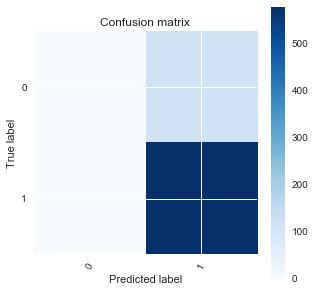

In [722]:
clf = SVC(
        C=10, # Penalty parameter C of the error term; default = 1.0
        cache_size=200, # The size of the kernel cache (in MB).
        class_weight=None, # Set the parameter C of class i to class_weight[i]*C for SVC
        coef0=0.0,  # Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’.
        degree=3, # Degree of the polynomial kernel function (‘poly’); default = 3. Ignored by all other kernels.
        gamma=0.1, # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’; auto = 1/n_features
#Higher the value of gamma, will try to exact fit the as per training data set, cause over-fitting problem.
        kernel='rbf',  # Specifies the kernel type to be used in the algorithm; default = "rbf"
        max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit; default = -1
        probability=True, # Whether to enable probability estimates; default = False
        random_state=101, # To set a random state for replicability
        shrinking=True, # Whether to use the shrinking heuristic; default = True
        tol=0.001, # Tolerance for stopping criterion; default = 0.001
        verbose=False  # Enable verbose output; default = False
    )

clf.fit(X_train, Y_train)

Y_pred_svm = clf.predict(X_test)
print()

SVM_predprobability = clf.predict_proba(X_test)
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix)

So SVM took a while...but got 84%.  This is misleading, because it predicted ALL test observations to be '1'!! Therefore, the accuracy simply matches the underlying distribution of the output, between '0' and '1'.  Let's see if tuning SVM does any better.

In [724]:
# penalties = [0.1,0.5, 1.0, 5, 10, 100]
# cv = 10 
# acc_scores = np.zeros((len(penalties),cv))
# scores_list = []
# for i, k in enumerate (penalties):
#     clf = SVC(C=k, gamma=0.1, probability=True, random_state=55 )
#     acc_scores[i,:] = cross_val_score(clf, X_train, Y_train, cv=cv, scoring='f1')  
#     scores_list.append(acc_scores[i,:])
# #print (acc_scores)

So the Cost parameter tuning took waaaay too long, so I stopped the kernel.  Maybe I will try running this tomorrow and see if it actually completes after an hour or more. For now I will try a few different parameters manually to see if there are any drastic performance increases.

In [785]:
#Try Cost=100, degree=3, kernel='poly', gamma=0.01

clf = SVC(C=100,degree=3,kernel='poly',max_iter=20,gamma=0.01, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

In [786]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])

In [787]:
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)

AUC with SVM:  0.549307958478


In [788]:
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)

Confusion_matrix: 
 [[  4 106]
 [ 22 556]]


In [790]:
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

Accuracy score: 
 0.813953488372 



Hmmmm, so it looks like SVM, as tuned thus far, has a very high "FPR", or False Positive Rate.  

That is, SVM model predicted 106 '1's that were actually '0's.  How to remedy this?  That is the question.

In [793]:
#Try train_test_split on the 'x_train_features' subset of training data, from the RandomForest tuning in the beginning

#Split into training and test set - where the latter is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_features, y, test_size=.20, random_state=10) 
print (x_train_features.shape, X_train.shape, X_test.shape)

(4584, 65) (3667, 65) (917, 65)


In [794]:
#Scale to standard normal
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [805]:
#cost = 10
clf = SVC(C=10,degree=3,kernel='poly',max_iter=20,gamma=0.01, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

AUC with SVM:  0.52832309717
Confusion_matrix: 
 [[  1 140]
 [ 16 760]]
Accuracy score: 
 0.829880043621 



In [806]:
#degrees = 4
clf = SVC(C=10,degree=4,kernel='poly',max_iter=20,gamma=0.01, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

AUC with SVM:  0.460060685823
Confusion_matrix: 
 [[  1 140]
 [  7 769]]
Accuracy score: 
 0.839694656489 



In [807]:
#gamma = 0.001
clf = SVC(C=10,degree=4,kernel='poly',max_iter=20,gamma=0.001, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

AUC with SVM:  0.433885354976
Confusion_matrix: 
 [[  0 141]
 [  3 773]]
Accuracy score: 
 0.842966194111 



In [837]:
#cost = 1000, kernel = 'rbf', gamma = 0.0001
clf = SVC(C=1000,degree=3,kernel='rbf',max_iter=20,gamma=0.0001, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

AUC with SVM:  0.595196314981
Confusion_matrix: 
 [[ 25 116]
 [102 674]]
Accuracy score: 
 0.762268266085 



In [843]:
#cost = 1000, kernel = 'sigmoid', gamma = 0.0001
clf = SVC(C=100,degree=3,kernel='sigmoid',max_iter=20,gamma=0.001, probability=True, random_state=123)
probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
Y_pred_svm = clf.predict(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with SVM: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

AUC with SVM:  0.481666301089
Confusion_matrix: 
 [[  3 138]
 [ 36 740]]
Accuracy score: 
 0.810250817884 



Let's try an ensemble method called 'VotingClassifier'. 

We'll try a few different SVM kernels to see if the ensemble is better than any one of the kernels so far.


In [844]:
#polynomial SVM kernel
clf1 = SVC(C=10,degree=4,kernel='poly',max_iter=20,gamma=0.001, probability=True, random_state=123)

#rbf SVM kernel
clf2 = SVC(C=1000,degree=3,kernel='rbf',max_iter=20,gamma=0.0001, probability=True, random_state=123)

#sigmoid SVM kernel
clf3 = SVC(C=100,degree=3,kernel='sigmoid',max_iter=20,gamma=0.001, probability=True, random_state=123)


In [845]:
clf_SVM_ensemble_1 = VotingClassifier(estimators=[('poly', clf1), ('rbf', clf2), ('sigmoid', clf3)], voting='hard')

In [849]:
clf_SVM_ensemble_1.fit(X_train, Y_train)

Y_pred_svm = clf_SVM_ensemble_1.predict(X_test)

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

Confusion_matrix: 
 [[  3 138]
 [ 17 759]]
Accuracy score: 
 0.830970556161 



In [850]:
clf_SVM_ensemble_2 = VotingClassifier(estimators=[('poly', clf1), ('rbf', clf2), ('sigmoid', clf3)], voting='soft')

In [851]:
clf_SVM_ensemble_2.fit(X_train, Y_train)

Y_pred_svm = clf_SVM_ensemble_2.predict(X_test)

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

Confusion_matrix: 
 [[  0 141]
 [  0 776]]
Accuracy score: 
 0.846237731734 



As far as False Positive Rate, the 'rbf' SVM kernel had the best performance, so I will try a Kaggle submission with this model, after standardizing both the training data and the test data.

In [859]:
#prepare the training and test data - get the reduced feature subset from RandomForest tuning at top of notebook

X_train = x_train_features
X_test = x_test_features

In [860]:
#Scale to standard normal
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [868]:
#Try the 'rbf' SVM kernel with previously tuned parameters
clf = SVC(C=1000,degree=3,kernel='rbf',max_iter=20,gamma=0.0001, probability=True, random_state=123).fit(X_train,y)

preds5 = clf.predict(X_test)


In [870]:
len(preds5)

1732

In [871]:
#Fifth Kaggle submission

submission5 = pd.DataFrame( {
    "id": df_dummies_test_index['index'],
    "output": preds5
})
submission5.to_csv('McNutt_Jonathan_5.csv', index=False)

My 5th Kaggle submission yielded an AUC score of 0.47614, worst yet!  Oh, boy.

In [872]:
#may really have to log+1 all data first, like in Section 6 notebook, and then remove the nan's somehow...

In [877]:
#Try the manually x,y,z coordinates dropped dataframe 'x_train_dropped'

#This time we will tune the SVM parameters with GridSearchCV

#Split into training and test set - where the latter is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_dropped, y, test_size=.15, random_state=10) 
print (x_train_dropped.shape, X_train.shape, X_test.shape)

(4584, 555) (3896, 555) (688, 555)


In [878]:
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [883]:
#I ran the GridSearchCV with the below parameters for over 2 hours!!! My CPU was at 100% the entire time
#and began to get very hot, so I finally stopped this cell manually.  


# from sklearn.model_selection import GridSearchCV   #Performing grid search

# param_test1 = {'C':[0.1,0.5, 1.0, 5, 10, 100], 'gamma':[0.001,0.01, 0.1, 1.0, 2.0], 
#               'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3,4], 'random_state': [37]}
# gsearch1 = GridSearchCV(estimator = SVC(), 
#                        param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=10)
# gsearch1.fit(X_train, Y_train)

# gsearch1.best_params_, gsearch1.best_score_

Unfortunately, I had to stop GridSearchCV on SVM because it ran for more than 2 hours at 100% CPU and my computer was getting VERY hot!  I didn't want to sacrifice my computer for the sake of GridSearchCV, so I will stick with my manually tuned SVM kernels for future usage (in ensemble methods, for example).

Since we had the best Kaggle success so far with RandomForest, and specifically on a reduced feature subset found with Feature Importances plot, let's try again, but starting with my manually reduced feature dataset (with 120 columns removed due to having "static" values).

In [896]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_dropped, y, test_size=.20, random_state=10) 
print (x_train_dropped.shape, X_train.shape, X_test.shape)

(4584, 555) (3667, 555) (917, 555)


In [899]:
#Trying 'balanced_subsample' for 'class_weight' parameter of RandomForest

clf = RandomForestClassifier( class_weight= 'balanced_subsample', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=101)
clf.fit(X_train,Y_train) 

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.918429003021
AUC with RandomForest:  0.733740951963
Confusion_matrix: 
 [[ 22 119]
 [ 16 760]]
Accuracy score: 
 0.852780806979 



In [900]:
#compare with 'balanced' class_weight

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 6, 
                             n_estimators= 50, random_state=101)
clf.fit(X_train,Y_train)

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.918886198547
AUC with RandomForest:  0.711870293193
Confusion_matrix: 
 [[ 24 117]
 [ 17 759]]
Accuracy score: 
 0.85387131952 



In [901]:
#Trying min_samples_split = 10, max_depth=15 and n_estimators = 100

clf = RandomForestClassifier( class_weight= 'balanced_subsample', max_depth= 15, min_samples_split= 10, 
                             n_estimators= 100, random_state=101)
clf.fit(X_train,Y_train) 

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.921241050119
AUC with RandomForest:  0.744689990495
Confusion_matrix: 
 [[ 13 128]
 [  4 772]]
Accuracy score: 
 0.856052344602 



In [904]:
#Trying min_samples_split = 20, max_depth=20 and n_estimators = 100, class_weight = 'balanced'

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)
clf.fit(X_train,Y_train) 

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.921241050119
AUC with RandomForest:  0.746892593405
Confusion_matrix: 
 [[ 13 128]
 [  4 772]]
Accuracy score: 
 0.856052344602 



In [908]:
clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)
clf.fit(x_train_dropped,y)
importance_list = clf.feature_importances_
name_list = df_dummies_train_dropped_columns.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
df3  = pd.DataFrame([name_list,importance_list]).T
df3.columns = ['Features','Importances']

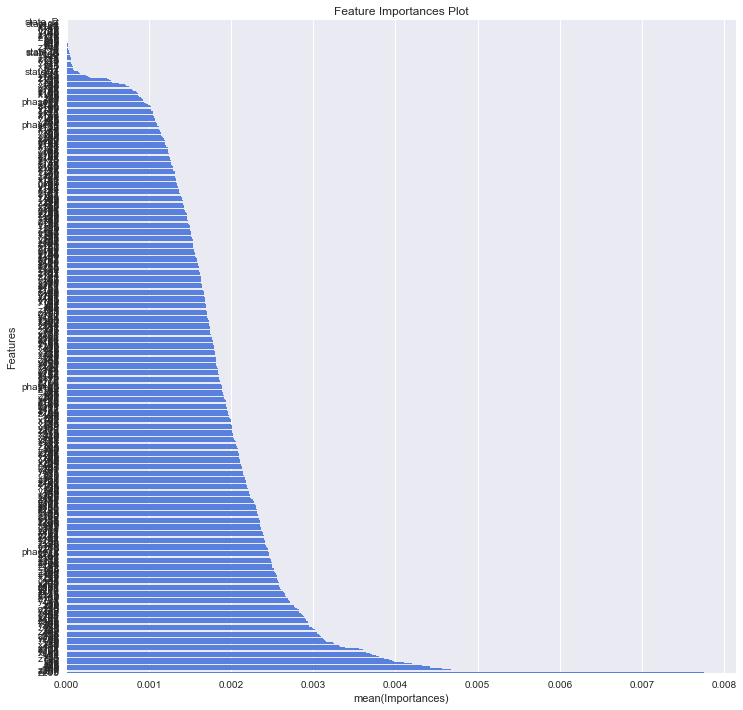

In [910]:
#Feature Importances Plot (first try)
f, ax = plt.subplots(figsize = (12,12))
sns.barplot(x='Importances',y='Features',data=df3, ci=None, color='#4476f4')
plt.title('Feature Importances Plot')
plt.show();

In [915]:
# we will take 0.002 as a first cut
df4 = df3[df3['Importances'] > 0.0025]
df4.shape

(90, 2)

In [913]:
#Our first feature importances cut yields 90 remaining "important" features. Let's cut the previous dataframe
#  (555 predictors) so that only these 90 remain and then try our RandomForest again.

In [930]:
#Let's only use the features from our Feature Importance plot above where 
# Feature Importance > 0.0025

important_features2 = df4.Features.as_matrix()
important_features2

array(['y33', 'y75', 'y34', 'z198', 'z109', 'x58', 'x187', 'z76', 'x212',
       'x7', 'y94', 'x18', 'x208', 'x204', 'x206', 'x191', 'y206', 'y108',
       'x207', 'y112', 'z210', 'z193', 'z15', 'z143', 'x112', 'z80',
       'z107', 'y221', 'y17', 'y9', 'y36', 'z12', 'z50', 'y13', 'z150',
       'y139', 'y219', 'x60', 'y109', 'z54', 'x5', 'y204', 'x202', 'x182',
       'z192', 'y202', 'z49', 'z38', 'y203', 'z75', 'z53', 'z13', 'z5',
       'x55', 'z202', 'z52', 'y55', 'z219', 'y220', 'x8', 'y205', 'y50',
       'y70', 'z18', 'z8', 'x153', 'x56', 'x152', 'z111', 'x203', 'y208',
       'y5', 'x205', 'y54', 'z51', 'x34', 'z55', 'z110', 'y8', 'x49',
       'x54', 'x51', 'z56', 'z58', 'z69', 'y56', 'z206', 'z207', 'x50',
       'z205'], dtype=object)

In [931]:
#create a new dataframe with only the 90 Training data columns deemed "important" by our Feature Importances plot
df_dummies_train_features2 = df_dummies_train_dropped_columns[important_features2]
df_dummies_train_features2.shape

(4584, 90)

In [932]:
x_train_features2 = df_dummies_train_features2.as_matrix()
x_train_features2

array([[  2.16390798e+00,   1.87474629e+00,  -6.36314332e-01, ...,
          8.59222530e-02,  -7.55435407e-01,   2.75763230e-01],
       [  2.15021726e+00,   1.77395036e+00,  -6.45812154e-01, ...,
         -1.89976900e-03,  -7.46451735e-01,   4.07122081e-01],
       [  2.16662523e+00,   1.80257981e+00,  -7.84367979e-01, ...,
          7.58729560e-02,  -5.95384657e-01,   3.01951989e-01],
       ..., 
       [  2.15343442e+00,   2.06142402e+00,  -5.74660260e-02, ...,
          2.26774284e-01,  -9.85998154e-01,   7.60300045e-01],
       [  2.06823277e+00,   2.19522175e+00,   9.73724870e-02, ...,
          3.40949440e-02,  -9.73420024e-01,   8.16176009e-01],
       [  2.18663249e+00,   2.19964819e+00,   1.64759000e-04, ...,
          1.12618530e-01,  -9.73349810e-01,   7.89348330e-01]])

In [933]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(x_train_features2, y, test_size=.20, random_state=10) 
print (x_train_features2.shape, X_train.shape, X_test.shape)

(4584, 90) (3667, 90) (917, 90)


In [934]:
#Try our "best" RandomForest model yet on this new subset of training features:

#Trying min_samples_split = 20, max_depth=20 and n_estimators = 100, class_weight = 'balanced'

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)
clf.fit(X_train,Y_train) 

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.91917973462
AUC with RandomForest:  0.760519485267
Confusion_matrix: 
 [[ 21 120]
 [ 14 762]]
Accuracy score: 
 0.85387131952 



In [935]:
#do the same for test data
df_dummies_test_features2 = df_dummies_test_dropped_columns[important_features2]
df_dummies_test_features2.shape

(1732, 90)

In [936]:
#get matrix form of the new test data subset of 90 "important" features
x_test_features2 = df_dummies_test_features2.as_matrix()
x_test_features2.shape

(1732, 90)

In [938]:
# #Make a sixth RandomForest prediction to submit to Kaggle 

# clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
#                              n_estimators= 100, random_state=101)

# #use 100% of training data for the fit!
# clf.fit(x_train_features2,y)

# #cutoff value of 0.5
# preds6 = cutoff_predict(clf,x_test_features2,0.5)

In [942]:
# #Sixth Kaggle submission

# submission6 = pd.DataFrame( {
#     "id": df_dummies_test_index['index'],
#     "output": preds6
# })
# submission6.to_csv('McNutt_Jonathan_6.csv', index=False)

Hmmmm, Kaggle says I have 'no more remaining submissions for today' until roughly 5 hours from now.....

I guess I'll move on to try other methods in the meantime?

In [943]:
#We can see from our previous subject versus output plots in the training data that Subject 'K' is always output = '1'.

#So the question is, how to make sure that the probability for subject K equals '1'.

# we want: preds = model.predict_proba(x_test)
# but ACTUALLY submit preds[:,1] as the Kaggle submission!!!!

#try feature engineering from Section 7 


In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [5]:
train.shape

(4584, 670)

In [6]:
test.shape

(1732, 669)

In [7]:
#code from Section 7

train['indicator']='train'
test['indicator']='test'

Y = train.output
train.drop('output',inplace=True, axis=1)


In [8]:
#code from Section 7

train_test = pd.concat([train,test])
train_test.reset_index(inplace=True, drop=True) #drop index
train_test.shape

(6316, 670)

In [9]:
#code from Section 7

#Creating Features
train_test['SubjectK'] = 0
train_test.loc[train_test[train_test.subject=='K'].index,'SubjectK']=1

In [10]:
#code from Section 7

#Step by step
i1 = train_test[((train_test.phase==1) & (train_test.subject=='A'))].index
arr = np.zeros(train_test.shape[0],dtype=int)
arr[i1]=1
train_test['SubA_Phase1']=arr

#concise
train_test['SubI_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='I'))].index,'SubI_Phase1'] = 1

train_test['SubM_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='M'))].index,'SubM_Phase1'] = 1

train_test['SubA_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='A'))].index,'SubA_Phase2'] = 1

train_test['SubF_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='F'))].index,'SubF_Phase2'] = 1

train_test['SubI_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='I'))].index,'SubI_Phase3'] = 1

train_test['SubL_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='L'))].index,'SubL_Phase3'] = 1

train_test['SubL_Phase4'] = 0
train_test.loc[train_test[((train_test.phase==4) & (train_test.subject=='L'))].index,'SubL_Phase4'] = 1

In [11]:
#code from Section 7 

train_1 = train_test[train_test.indicator=='train']
test_1 = train_test[train_test.indicator=='test']
train_1.reset_index(inplace=True,drop=True)
test_1.reset_index(inplace=True,drop=True)

In [12]:
#Get dummy variables for Training and Test categorical data: state
df_state_train = pd.get_dummies(train_1['state'], prefix = 'state')  
df_state_test = pd.get_dummies(test_1['state'], prefix = 'state') 

In [13]:
#Get dummy variables for Training and Test categorical data: phase
df_phase_train = pd.get_dummies(train_1['phase'], prefix = 'phase')
df_phase_test = pd.get_dummies(test_1['phase'], prefix = 'phase') 

In [14]:
#Get dummy variables for Training and Test categorical data: subject
df_subject_train = pd.get_dummies(train_1['subject'], prefix = 'subject')
df_subject_test = pd.get_dummies(test_1['subject'], prefix = 'subject') 

In [15]:
df_subject_train.head()

,subject_A,subject_B,subject_C,subject_D,subject_F,subject_G,subject_H,subject_I,subject_K,subject_L,subject_M
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [16]:
df_subject_test.head()

,subject_A,subject_B,subject_C,subject_D,subject_E,subject_F,subject_G,subject_H,subject_I,subject_J,subject_K,subject_L,subject_M
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#since the Test data has two more subjects than Training: subject 'E' and 'J', let's drop these two from the test df
df_subject_test.drop('subject_E',inplace=True, axis=1)
df_subject_test.drop('subject_J',inplace=True, axis=1)

In [18]:
#Drop the three categorical columns plus the added indicator column
train_1 = train_1.drop(['state','subject','phase','indicator'], axis=1)
test_1 = test_1.drop(['state','subject','phase','indicator'], axis=1)

In [19]:
#Concatenate the new Training dummy variable dataframes with the predictors training dataframe
train_1 = pd.concat([train_1, df_state_train, df_phase_train, df_subject_train], axis = 1)
test_1 = pd.concat([test_1, df_state_test, df_phase_test, df_subject_test], axis = 1)

In [20]:
train_1.shape

(4584, 695)

In [21]:
test_1.shape

(1732, 695)

In [987]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 695) (3667, 695) (917, 695)


In [988]:
#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862) #missing = -999

model.fit(X_train,Y_train, eval_metric='auc')
probas_ = model.predict_proba(X_test) #submit these predictions

Y_pred = model.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.87741046832
AUC with XGBoost:  0.867953498574
Confusion_matrix: 
 [[102  39]
 [139 637]]
Accuracy score: 
 0.805888767721 



WOW!  Highest AUC score yet!! (for me, anyway)  

So let's try our best RandomForest model against this XGBoost model before submitting one of them (whichever wins) on Kaggle leaderboard.

In [989]:
#Try our "best" RandomForest model yet on this new subset of training features:

#Trying min_samples_split = 20, max_depth=20 and n_estimators = 100, class_weight = 'balanced'

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)
clf.fit(X_train,Y_train) 

probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.923169267707
AUC with RandomForest:  0.823572420853
Confusion_matrix: 
 [[ 20 121]
 [  7 769]]
Accuracy score: 
 0.860414394766 



OK, looks like I would need to get an "Important Features" subset in order to maximize RandomForest, even with the feature engineering. Let's submit the XGBoost model to see the results on Kaggle.

In [991]:
#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(train_1,Y, eval_metric='auc')
preds = model.predict_proba(test_1) #submit these predictions

In [992]:
submission6 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission6.columns = ['id','output']
submission6.id = submission6.id.astype(int)
submission6.to_csv('McNutt_Jonathan_6.csv',index=False)

YEEEEEEEESSSSSSS!!! My 6th Kaggle submission moved me up to 4th overall, with an AUC score of 0.74444!!  

So clearly, something crazy must be done in order to break into the 0.8 range.  Let's try the feature importances to reduce the number of variables and try again.

In [1016]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.15, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 695) (3896, 695) (688, 695)


In [1017]:
#Create an XGBoost model based on parameters above:

model = xgb.XGBClassifier(seed=82, n_estimators=1000 , max_depth=5, min_child_weight=6,
                          gamma=0, colsample_bylevel=0.8, objective= 'binary:logistic',nthread=4,
                          colsample_bytree=0.8,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(X_train,Y_train, eval_metric='auc')
probas_ = model.predict_proba(X_test) #submit these predictions

Y_pred = model.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.908462867012
AUC with XGBoost:  0.860537574405
Confusion_matrix: 
 [[ 56  56]
 [ 50 526]]
Accuracy score: 
 0.845930232558 



In [ ]:
#next try dropping those 120 columns I found 'manually' by verifying in Excel that those columns had 'static' values

In [1032]:
x_coordinates = []
y_coordinates = []
z_coordinates = []

In [1035]:
#Get a list of x-coordinates to drop, then y-coordinates, then z-coordinates, then combine, then drop from dataframe

x_coordinates = ['x1','x2','x3','x14','x39','x47','x48','x57','x72','x73','x74','x81','x86','x87','x91','x92',
                 'x93','x96','x97','x98','x99','x103','x104','x105','x113','x118','x119','x120','x121','x122',
                 'x123','x124','x125','x126','x127','x128','x129','x130','x131','x132']

In [1037]:
y_coordinates = ['y1','y2','y3','y14','y39','y47','y48','y57','y72','y73','y74','y81','y86','y87','y91','y92',
                 'y93','y96','y97','y98','y99','y103','y104','y105','y113','y118','y119','y120','y121','y122',
                 'y123','y124','y125','y126','y127','y128','y129','y130','y131','y132']

In [1038]:
z_coordinates = ['z1','z2','z3','z14','z39','z47','z48','z57','z72','z73','z74','z81','z86','z87','z91','z92',
                 'z93','z96','z97','z98','z99','z103','z104','z105','z113','z118','z119','z120','z121','z122',
                 'z123','z124','z125','z126','z127','z128','z129','z130','z131','z132']

In [18]:
columns_to_drop = []
columns_to_drop.extend(x_coordinates)

In [19]:
columns_to_drop.extend(y_coordinates)

In [20]:
columns_to_drop.extend(z_coordinates)

In [21]:
#Final list of columns to drop from the training AND test data 
print("Length of array of columns to drop: ",len(columns_to_drop),"\n")
print(columns_to_drop)

Length of array of columns to drop:  120 

['x1', 'x2', 'x3', 'x14', 'x39', 'x47', 'x48', 'x57', 'x72', 'x73', 'x74', 'x81', 'x86', 'x87', 'x91', 'x92', 'x93', 'x96', 'x97', 'x98', 'x99', 'x103', 'x104', 'x105', 'x113', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'y1', 'y2', 'y3', 'y14', 'y39', 'y47', 'y48', 'y57', 'y72', 'y73', 'y74', 'y81', 'y86', 'y87', 'y91', 'y92', 'y93', 'y96', 'y97', 'y98', 'y99', 'y103', 'y104', 'y105', 'y113', 'y118', 'y119', 'y120', 'y121', 'y122', 'y123', 'y124', 'y125', 'y126', 'y127', 'y128', 'y129', 'y130', 'y131', 'y132', 'z1', 'z2', 'z3', 'z14', 'z39', 'z47', 'z48', 'z57', 'z72', 'z73', 'z74', 'z81', 'z86', 'z87', 'z91', 'z92', 'z93', 'z96', 'z97', 'z98', 'z99', 'z103', 'z104', 'z105', 'z113', 'z118', 'z119', 'z120', 'z121', 'z122', 'z123', 'z124', 'z125', 'z126', 'z127', 'z128', 'z129', 'z130', 'z131', 'z132']


In [1050]:
#drop the columns from train and test data
train_1 = train_1.drop(columns_to_drop, axis=1)
test_1 = test_1.drop(columns_to_drop, axis=1)

In [1051]:
train_1.shape

(4584, 575)

In [1052]:
test_1.shape

(1732, 575)

In [1053]:
#Now try the same XGBoost model to see if the AUC score increased:

#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 575) (3667, 575) (917, 575)


In [1054]:
#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862) #missing = -999

model.fit(X_train,Y_train, eval_metric='auc')
probas_ = model.predict_proba(X_test) #submit these predictions

Y_pred = model.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.878015161957
AUC with XGBoost:  0.867231483512
Confusion_matrix: 
 [[103  38]
 [139 637]]
Accuracy score: 
 0.806979280262 



In [1056]:
#Try VotingClassifier without XGBoost first

clf1 = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)

clf2 = LogisticRegression(random_state=1)

clf3 = KNeighborsClassifier(n_neighbors = 15, weights='distance')

eclf = VotingClassifier(estimators=[('rf',clf1),('lr',clf2),('knn',clf3)], voting='soft')

eclf = eclf.fit(X_train,Y_train)

probas_ = eclf.predict_proba(X_test) #submit these predictions

Y_pred = eclf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with VotingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')



f1 score is:  0.92380952381
AUC with XGBoost:  0.822210645609
Confusion_matrix: 
 [[ 13 128]
 [  0 776]]
Accuracy score: 
 0.860414394766 



In [1057]:
#Try VotingClassifier with XGBoost

clf1 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

clf2 = LogisticRegression(random_state=1)

clf3 = KNeighborsClassifier(n_neighbors = 15, weights='distance')

eclf = VotingClassifier(estimators=[('xgb',clf1),('lr',clf2),('knn',clf3)], voting='soft')

eclf = eclf.fit(X_train,Y_train)

probas_ = eclf.predict_proba(X_test) #submit these predictions

Y_pred = eclf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with VotingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')



f1 score is:  0.915604128719
AUC with XGBoost:  0.849811727718
Confusion_matrix: 
 [[ 24 117]
 [ 22 754]]
Accuracy score: 
 0.848418756816 



In [1058]:
#Let's try sending another prediction to Kaggle, this time with the 120 dropped columns from the training/test data

#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(train_1,Y, eval_metric='auc')
preds = model.predict_proba(test_1) #submit these predictions

In [1059]:
submission7 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission7.columns = ['id','output']
submission7.id = submission7.id.astype(int)
submission7.to_csv('McNutt_Jonathan_7.csv',index=False)

7th Kaggle submission: 0.74125 so it went down actually from my previous submission with XGBoost! 

Next, we'll try feature selection with 'SelectFromModel', adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/


In [1121]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 575) (3667, 575) (917, 575)


In [1122]:
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1)

In [1137]:
thresholds = model.feature_importances_
len(thresholds)

575

In [1123]:
selection = SelectFromModel(model, threshold=0.005, prefit=True)

In [1124]:
selection

SelectFromModel(estimator=XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1),
        prefit=True, threshold=0.005)

In [1125]:
selection_X_train = selection.transform(X_train)
selection_X_train.shape

(3667, 44)

In [1126]:
selection_X_train

array([[-1.28895891,  0.01209581,  0.01066089, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20934409,  0.004095  ,  0.00490321, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0068422 ,  0.00472206,  0.0051444 , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-1.73107755,  0.07014763,  0.04527746, ...,  0.        ,
         1.        ,  0.        ],
       [-0.94403845,  0.00372402,  0.002624  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.62815726,  0.08281768,  0.09770894, ...,  0.        ,
         0.        ,  0.        ]])

In [1130]:
selection_model = XGBClassifier()
selection_model.fit(selection_X_train, Y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [1132]:
X_test.shape


(917, 575)

In [1133]:
selection_X_test = selection.transform(X_test)
selection_X_test.shape

(917, 44)

In [1134]:
Y_test.shape

(917,)

In [1135]:

probas_ = selection_model.predict_proba(selection_X_test) #submit these predictions

Y_pred = selection_model.predict(selection_X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.921770770164
AUC with VotingClassifier:  0.856364699861
Confusion_matrix: 
 [[ 28 113]
 [ 16 760]]
Accuracy score: 
 0.859323882225 



This was a pretty good results, but I manually decided on a threshold, so now let's programatically find the best threshold.

In [1147]:
selection_X_train.shape[1]

44

In [1144]:
thresholds = np.sort(model.feature_importances_)
print(thresholds)

#looks like 0.001 would be a good threshold, but still, let's just run

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [1149]:
#just get the thresholds higher than 0.001 for the for loop (otherwise will take too long)
thresholds = np.sort([i for i in thresholds if i >= 0.001])
len(thresholds)
#down to 198 important features from 575...great!

198

In [1151]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 575) (3667, 575) (917, 575)


In [1156]:
#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(X_train,Y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1)

In [1157]:
selection = SelectFromModel(model, threshold=0.001, prefit=True)

In [1158]:
selection_X_train = selection.transform(X_train)
selection_X_train.shape

(3667, 198)

In [1159]:
selection_model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)
selection_model.fit(selection_X_train, Y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1)

In [1160]:
selection_X_test = selection.transform(X_test)
selection_X_test.shape

(917, 198)

In [1161]:
probas_ = selection_model.predict_proba(selection_X_test) #submit these predictions

Y_pred = selection_model.predict(selection_X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.882191780822
AUC with XGBoost:  0.865476712729
Confusion_matrix: 
 [[101  40]
 [132 644]]
Accuracy score: 
 0.812431842966 



Not highest AUC yet, but still very high.  Let's try Kaggle again with the features we found important through SelectFromModel with threshold = 0.001.

In [1162]:
#Create a model on complete training set for Kaggle submission

model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(train_1,Y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1)

In [1163]:
selection = SelectFromModel(model, threshold=0.001, prefit=True)

In [1164]:
selection_X_train = selection.transform(train_1)
selection_X_train.shape

(4584, 163)

In [1165]:
selection_model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)
selection_model.fit(selection_X_train, Y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=0.18357862, seed=82, silent=True, subsample=1)

In [1166]:
selection_X_test = selection.transform(test_1)
selection_X_test.shape

(1732, 163)

In [1167]:
preds = selection_model.predict_proba(selection_X_test) #submit these predictions

In [1168]:
submission8 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission8.columns = ['id','output']
submission8.id = submission7.id.astype(int)
submission8.to_csv('McNutt_Jonathan_8.csv',index=False)

8th Kaggle submission was 0.74323, my second highest score so far.  Not bad, but still in 7th place on the leaderboard!  Need to pull out all the stops to keep moving up...

time to check some of the data again to see if we can do any more feature engineering like in Section 7.

In [1195]:
#read in the data again (because we dropped the output column)
train_2 = pd.read_csv('train_data.csv')

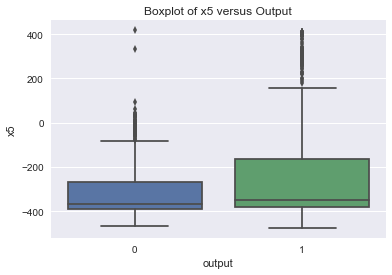

In [1206]:
#try some Seaborn for a change:

sns.boxplot(x='output',y='x5', data = train_2).set_title('Boxplot of x5 versus Output');

I actually ran the code in the cell below, but it took several minutes to run, so I'll leave it commented out here in case computation power (and time) is limited for the grader.  I made some comments though to summarize.

In [1213]:
# # this code loops through the entire training data, and plots a barplot of each column against output, 
#   so that I could visualize the distribution of the continuous variables per output outcome ('0' or '1').
#   As it turns out, they all looked very similar, so not very helpful from that standpoint, unfortunately.
#   Looks like I will need to go back to some sort of ensemble method to squeeze out a bit more AUC 'juice'.

# for i, column in enumerate(train_2.columns):
#     plt.figure(i)
#     sns.boxplot(x='output',y=column,data=train_2).set_title('Boxplot of '+column+' versus Output')

In [1250]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 575) (3667, 575) (917, 575)


In [1254]:
# Try Adaboost Classifier

clf = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

clf.fit(X_train, Y_train)

probas_ = clf.predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with Adaboost: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.918590522479
AUC with Adaboost:  0.808236455363
Confusion_matrix: 
 [[ 27 114]
 [ 20 756]]
Accuracy score: 
 0.85387131952 



In [1256]:
# Try RandomForest Classifier

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)

clf.fit(X_train, Y_train)

probas_ = clf.predict_proba(X_test)

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.92206235012
AUC with Adaboost:  0.840160488411
Confusion_matrix: 
 [[ 18 123]
 [  7 769]]
Accuracy score: 
 0.858233369684 



In [1258]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [1259]:
# Try Logistic Classifier

clf = LogisticRegression(random_state=101,class_weight='balanced')

clf.fit(X_train_std, Y_train)

probas_ = clf.predict_proba(X_test_std)

Y_pred = clf.predict(X_test_std)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.847075405215
AUC with RandomForest:  0.81969730204
Confusion_matrix: 
 [[ 99  42]
 [175 601]]
Accuracy score: 
 0.763358778626 



In [1266]:
from sklearn.pipeline import Pipeline, FeatureUnion

clf = KNeighborsClassifier(n_neighbors = 10, metric='euclidean', weights='distance', n_jobs=-1)

clf.fit(X_train_std, Y_train)

# Create a pipeline
pipe = Pipeline([('standardizer', scaler), ('knn', clf)])

# Create space of candidate values
search_space = [{'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

In [1267]:
# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train_std, Y_train)

In [1268]:
# Best neighborhood size (k)
clf.best_estimator_.get_params()['knn__n_neighbors']

8

GREAT!  GridSearchCV FINALLY gave me something to work with (previously took over 2 hours at 100% CPU and did not finish).  So let's try n_neighbors = 8 and then throw KNN back into the ensemble afterwards.

In [1269]:
#K Nearest Neighbors

clf = KNeighborsClassifier(n_neighbors = 8, metric='euclidean', weights='distance', n_jobs=-1)

clf.fit(X_train_std, Y_train)

probas_ = clf.predict_proba(X_test_std)

Y_pred = clf.predict(X_test_std)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with RandomForest: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.91591046582
AUC with RandomForest:  0.743177414638
Confusion_matrix: 
 [[ 21 120]
 [ 19 757]]
Accuracy score: 
 0.848418756816 



In [1270]:
#Try VotingClassifier with XGBoost, Log, and KNN

clf1 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

clf2 = LogisticRegression(random_state=101,class_weight='balanced')

clf3 = KNeighborsClassifier(n_neighbors = 8, weights='distance')

eclf = VotingClassifier(estimators=[('xgb',clf1),('lr',clf2),('knn',clf3)], voting='soft')

eclf = eclf.fit(X_train_std,Y_train)

probas_ = eclf.predict_proba(X_test_std) #submit these predictions

Y_pred = eclf.predict(X_test_std)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with VotingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.897418927862
AUC with VotingClassifier:  0.854335746143
Confusion_matrix: 
 [[ 84  57]
 [ 98 678]]
Accuracy score: 
 0.830970556161 



In [1275]:
#Try VotingClassifier with XGBoost, RandomForest, and AdaBoost

clf1 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

clf2 = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)

clf3 = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

eclf = VotingClassifier(estimators=[('xgb',clf1),('rf',clf2),('ada',clf3)], voting='soft')

eclf = eclf.fit(X_train,Y_train)

probas_ = eclf.predict_proba(X_test) #submit these predictions

Y_pred = eclf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with VotingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.917197452229
AUC with VotingClassifier:  0.879432624113
Confusion_matrix: 
 [[ 67  74]
 [ 56 720]]
Accuracy score: 
 0.858233369684 



GREAT! AUC of 0.8794 is my best yet, so let's submit to Kaggle

In [1277]:
#Kaggle Model 9: VotingClassifier with XGBoost, RandomForest, and AdaBoost

clf1 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

clf2 = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)

clf3 = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

eclf = VotingClassifier(estimators=[('xgb',clf1),('rf',clf2),('ada',clf3)], voting='soft')

eclf = eclf.fit(train_1,Y)

preds = eclf.predict_proba(test_1) #submit these predictions

In [1278]:
submission9 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission9.columns = ['id','output']
submission9.id = submission7.id.astype(int)
submission9.to_csv('McNutt_Jonathan_9.csv',index=False)

9th submission got a 0.71180.  Not so hot. :(  Hmmmm....something drastically different must be tried.  Stand back.  This could get ugly....

In [22]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.20, random_state=10) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 695) (3667, 695) (917, 695)


In [23]:
#trying StackingClassifier from mlxtend package

clf1 = GaussianNB()
clf2 = RandomForestClassifier(random_state=101)
clf3 = KNeighborsClassifier(n_neighbors=1)
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)

sclf = sclf.fit(X_train,Y_train)

probas_ = sclf.predict_proba(X_test) #submit these predictions

Y_pred = sclf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with StackingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.879795396419
AUC with VotingClassifier:  0.726452255612
Confusion_matrix: 
 [[ 41 100]
 [ 88 688]]
Accuracy score: 
 0.794983642312 



In [26]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [27]:
#same three classifiers stacked with StackingClassifier rather than VotingClassifer as before

clf1 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

clf2 = RandomForestClassifier( class_weight= 'balanced', max_depth= 20, min_samples_split= 20, 
                             n_estimators= 100, random_state=101)

clf3 = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

knn = KNeighborsClassifier(n_neighbors=8,metric='euclidean',n_jobs=-1)

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=knn)

sclf = sclf.fit(X_train_std,Y_train)

probas_ = sclf.predict_proba(X_test_std) #submit these predictions

Y_pred = sclf.predict(X_test_std)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with StackingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.920238095238
AUC with StackingClassifier:  0.533528003217
Confusion_matrix: 
 [[ 10 131]
 [  3 773]]
Accuracy score: 
 0.85387131952 



In [122]:
#try XGBoost again

#use DMatrix on the training data before passing to model for fitting
train_matrix = xgb.DMatrix(X_train.as_matrix(), label=Y_train.tolist())
test_matrix = xgb.DMatrix(X_test.as_matrix())

In [123]:
parameters = {'max_depth': 3,
              'objective': 'multi:softprob',
              'eval_metric': 'auc',
              'num_class': 2,
              'n_estimators': 1000,
              'learning_weight': 0.01
             }


In [124]:
model = xgb.train(parameters, train_matrix, 100)

In [125]:
Y_pred = model.predict(test_matrix)
Y_pred[:,1]

array([  9.99146461e-01,   9.99607980e-01,   9.99788105e-01,
         9.18371201e-01,   9.90989923e-01,   9.59613919e-01,
         9.69444275e-01,   2.55102426e-01,   9.99981165e-01,
         9.85837877e-01,   9.99540567e-01,   9.46889341e-01,
         9.99487758e-01,   8.82500172e-01,   9.99891162e-01,
         9.99991775e-01,   9.99752939e-01,   9.49111164e-01,
         9.99977112e-01,   9.67344701e-01,   9.99891877e-01,
         9.32148635e-01,   9.99073505e-01,   9.58672285e-01,
         3.62856865e-01,   9.98946726e-01,   7.89755225e-01,
         5.41769683e-01,   9.99527812e-01,   9.99872327e-01,
         8.59876335e-01,   9.89423931e-01,   9.99490619e-01,
         9.81985688e-01,   9.99337256e-01,   9.95946109e-01,
         5.84220171e-01,   9.99894619e-01,   9.21978772e-01,
         9.76881087e-01,   9.99903798e-01,   9.95204926e-01,
         6.30583823e-01,   9.92823005e-01,   9.76470828e-01,
         9.06519294e-01,   9.04586434e-01,   9.96734917e-01,
         8.96422327e-01,

In [126]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with XGBoost: " , roc_auc)

AUC with XGBoost:  0.847558857937


In [142]:
#tune the RandomForest n_estimators parameter:

min_estimators = 40
max_estimators = 80

clf = RandomForestClassifier(criterion='entropy', warm_start=True, oob_score=True, random_state=101)

# for i in range(min_estimators, max_estimators+1):
#     clf.set_params(n_estimators=i)
#     clf.fit(X_train,Y_train)
#     oob_score = clf.oob_score_
#     print(i, oob_score)

#best Out-Of-Bag score was n_estimators = 70

In [174]:
#Let's switch gears and try an all tree boosting ensemble

clf1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf3 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf4 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf5 = GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, max_depth=6, n_estimators=100)
clf6 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)
clf7 = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

vclf = VotingClassifier(estimators=[('rfgini',clf1),('rfentropy',clf2),('extgini',clf3),
                                   ('extentropy',clf4), ('gbc',clf5), ('xgb',clf6), ('ada',clf7)
                                   ], voting='soft')

vclf = vclf.fit(X_train_std,Y_train)

probas_ = vclf.predict_proba(X_test_std) #submit these predictions

Y_pred = vclf.predict(X_test_std)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with StackingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')


f1 score is:  0.923536439665
AUC with StackingClassifier:  0.888736565036
Confusion_matrix: 
 [[ 16 125]
 [  3 773]]
Accuracy score: 
 0.860414394766 



AUC score of 0.88873! best score so far (before Kaggle submission).

Let's try it.

In [177]:
clf1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf3 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf4 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf5 = GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, max_depth=6, n_estimators=100)
clf6 = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)
clf7 = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=101)

vclf = VotingClassifier(estimators=[('rfgini',clf1),('rfentropy',clf2),('extgini',clf3),
                                   ('extentropy',clf4), ('gbc',clf5), ('xgb',clf6), ('ada',clf7)
                                   ], voting='soft')

vclf = vclf.fit(train_1,Y)

preds = vclf.predict_proba(test_1) #submit these predictions

In [178]:
submission10 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission10.columns = ['id','output']
submission10.id = submission10.id.astype(int)
submission10.to_csv('McNutt_Jonathan_10.csv',index=False)

10th Kaggle submission was a humble 0.69342.  I have no idea what happened here. This ensemble method got my best AUC score yet on my own X_test data!  And yet the Kaggle score went DOWN!??  

I'm seriously at a loss for how to improve the Kaggle score now, since it seems inversely proportional to my notebook AUC score.


In [182]:
#Let's switch gears and try an all tree boosting ensemble

clf1 = GradientBoostingClassifier(learning_rate=.1, subsample=0.5, max_depth=6, n_estimators=100)
clf2 = xgb.XGBClassifier(seed=82, n_estimators=100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.1, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)
clf3 = AdaBoostClassifier(n_estimators=100,learning_rate=.1,random_state=101)

vclf = VotingClassifier(estimators=[('gbc',clf1), ('xgb',clf2), ('ada',clf3)
                                   ], voting='soft')

vclf = vclf.fit(X_train,Y_train)

probas_ = vclf.predict_proba(X_test) #submit these predictions

Y_pred = vclf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with StackingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.915466499687
AUC with StackingClassifier:  0.862360166703
Confusion_matrix: 
 [[ 51  90]
 [ 45 731]]
Accuracy score: 
 0.852780806979 



In [185]:
clf = GradientBoostingClassifier(learning_rate=.01, subsample = 1, max_depth = 3, 
                                 n_estimators=1000, min_samples_split=2)

clf = clf.fit(X_train,Y_train)

probas_ = clf.predict_proba(X_test) #submit these predictions

Y_pred = clf.predict(X_test)

print("f1 score is: ", f1_score(Y_test,Y_pred)) 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC with StackingClassifier: " , roc_auc)
# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print ('Confusion_matrix: \n', confusion_matrix)
# Print out accuracy
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred), '\n')

f1 score is:  0.923076923077
AUC with StackingClassifier:  0.851347152153
Confusion_matrix: 
 [[ 28 113]
 [ 14 762]]
Accuracy score: 
 0.861504907306 



In [204]:
#Split into training and test set - where the latter is 20% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(train_1, Y, test_size=.33, random_state=20) 
print (train_1.shape, X_train.shape, X_test.shape)

(4584, 695) (3071, 695) (1513, 695)


In [211]:
from sklearn import svm

clf = svm.SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.5,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=100, probability=True, random_state=101, shrinking=True,
  tol=0.001, verbose=False)

clf = clf.fit(train_1,Y)

preds = clf.predict_proba(test_1) #submit these predictions


In [212]:
submission11 = pd.DataFrame([test_1.index,preds[:,1]]).T
submission11.columns = ['id','output']
submission11.id = submission11.id.astype(int)
submission11.to_csv('McNutt_Jonathan_11.csv',index=False)

In [3]:
#try plotting some continuous variables against categorical, colored by the output

train3 = pd.read_csv('train_data.csv')
test3 = pd.read_csv('test_data.csv')

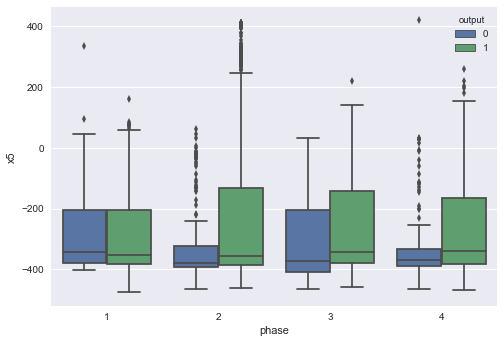

In [8]:
sns.boxplot(x="phase", y="x5", hue="output", data=train3);

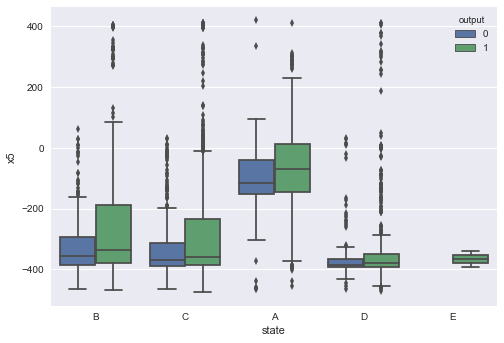

In [9]:
sns.boxplot(x="state", y="x5", hue="output", data=train3);

In [23]:
#drop the columns from train and test data
train3 = train3.drop(columns_to_drop, axis=1)
test3 = test3.drop(columns_to_drop, axis=1)

In [24]:
train3.shape

(4584, 550)

In [25]:
test3.shape

(1732, 549)

In [36]:
# for i, column in enumerate(train3.columns):
#     plt.figure(i)
#     sns.violinplot(x='state',y=column,hue='output', data=train3, split=True).set_title('Boxplot of '+column+' versus State')
#     plt.show()

State Versus Columns, Colored by Output:

State B: x5 > 0 then '1'
State A: x8 < -50 then '0'
State A: x12 > 0.5 then '1'
State A: x13 > 0.5 then '1'
State B: x24 < -0.15 then '0'
State C: x24 < -0.15 then '0'
State A: x24 < -0.2 then '0'
State B: x41 > 1.1 then '0'  #X41 important
State C: x41 > 1.1 then '0'
State D: x41 > 1.1 then '0'
State A: x41 > 1.08 then '0'
State D: x76 < -0.025 then '0'

KEY:
State B: x106 > 440 then '0'
State C: x106 > 440 then '0'
State A: x106 > 440 then '0'
State D: x106 > 440 then '0'

KEY:
State C: x116 > 1.05 then '0'
KEY:
State B: x117 > 1.05 then '0'
State C: x117 > 1.05 then '0'
KEY:
State B: x201 < -0.5 then '0'
State C: x201 < -0.5 then '0'
KEY:
State B: x202 < -0.1 then '0'
State D: x202 < -0.1 then '1'
KEY:
State B: x203 < -0.1 then '0'
KEY:
State A: x205 > 1.0 then '1'


In [37]:
# for i, column in enumerate(train3.columns):
#     plt.figure(i)
#     sns.violinplot(x='phase',y=column,hue='output', data=train3, split=True).set_title('Boxplot of '+column+' versus Phase')
#     plt.show()

Phase 2: x145 > .25 then '1' 
Phase 2: x146 > .25 then '1' 
Phase 2: x147 > .25 then '1' 
Phase 2: x148 > .1 then '1' 
Phase 2: x149 > .5 then '1' 
Phase 2: x150 > .5 then '1' 
Phase 2: x151 > .25 then '1' 
Phase 2: x152 > .25 then '1' 
Phase 2: x153 > .25 then '1' 
Phase 2: x154 > .25 then '1' 
Phase 2: x155 > .25 then '1' 
Phase 2: x156 > .25 then '1' 
Phase 2: x157 > .1 then '1' 
Phase 2: x158 > .25 then '1' 
Phase 2: x159 > .25 then '1'
Phase 2: x160 > .25 then '1' 
Phase 2: x162 > .25 then '1'  
x163 same 
x164 same
x166 same
x167 same
x168 same
x170 same
x171 same
x172 same
x174 same
x175 same
x176 same
x178 same
x179 same
x180 same
x182 same
x183 same
x184 same
x186 same
x187 same
x188 same
x190 same
x191 same






phase 2: x35 > 0.5 then '1'
phase 1: x35 < -1.75 then '1'
phase 4: x35 < -1.75 then '0'

phase 1: x41 > 1.1 then '0'
phase 2: x41 > 1.1 then '0'
phase 3: x41 > 1.1 then '0'
phase 4: x41 > 1.1 then '0'

phase 2: x49 > .25 then '1'
phase 2: x50 > .25 then '1'
phase 2: x51 > .25 then '1'
phase 2: x52 > .25 then '1'
phase 2: x53 > .25 then '1'
x54 same
x55 same
x56 same

phase 4: x76 < -0.02 then '0'
x77 same
x78 same
x79 same
x80 same

KEY:
Phase 3: x106 > 450 then '0'
Phase 1: x106 > 440 then '1'
Phase 2: x106 > 440 then '0'
Phase 4: x106 > 440 then '0'

KEY:
Phase 1: x114 > 1.15 then '0'
Phase 2: x114 > 1.15 then '0'

KEY:
Phase 1: x115 > 1.1 then '0'
Phase 3: x115 > 1.1 then '0'

KEY:
Phase 3: x116 > 1.1 then '0'

KEY:
Phase 1: x117 > 1.05 then '0'
Phase 3: x117 > 1.05 then '0'


